# Music genre prediction

**Описание задачи**

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса. Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

В ходе работы пройдите все основные этапы полноценного исследования:

*  загрузка и ознакомление с данными
*  предварительная обработка
*  полноценный разведочный анализ
*  разработка новых синтетических признаков
*  проверка на мультиколлинеарность
*  отбор финального набора обучающих признаков
*  выбор и обучение моделей
*  итоговая оценка качества предсказания лучшей модели
*  анализ важности ее признаков

**ВАЖНО**  
Необходимо реализовать решение с использованием технологии `pipeline` (из библиотеки `sklearn`)

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ**

* Оформленный репозиторий на GitHub (ноутбук с исследованием + код приложения)
* Развернутое web-приложение (с использованием библиотеки Streamlit)

## Участники проекта, репозиторий, приложение

...

...

## Импорт библиотек, установка констант

In [1]:
%%capture
!pip install catboost -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

In [3]:
TRAIN = "https://www.dropbox.com/scl/fi/5zy935lqpaqr9lat76ung/music_genre_train.csv?rlkey=ccovu9ml8pfi9whk1ba26zdda&dl=1"
TEST = "https://www.dropbox.com/scl/fi/o6mvsowpp9r3k2lejuegt/music_genre_test.csv?rlkey=ac14ydue0rzlh880jwj3ebum4&dl=1"

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и обзор данных

In [5]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

In [6]:
train.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
3981,63042.0,"Swan Lake, Op. 20, Act III No. 22: Act III In ...",0.798,0.302,151533.0,0.0521,0.231,D,0.0946,-23.400,Major,0.0385,91.413,4-Apr,0.447,Classical
6635,71274.0,Spill The Wine,0.440,0.847,244307.0,0.4590,0.000,D,0.0781,-11.793,Minor,0.0485,119.513,4-Apr,0.959,Blues
11550,45000.0,All Star Break Up,0.286,0.750,216744.0,0.6950,0.000,D,0.3020,-6.495,Major,0.2730,NaN,4-Apr,0.655,Rap
5220,33246.0,Caged Bird,0.140,0.592,239880.0,0.7660,0.000,D#,0.1360,-5.402,Minor,0.3100,82.039,4-Apr,0.362,Rap
19743,40741.0,エースの資質,0.289,0.171,123000.0,0.4340,0.969,F,0.0963,-16.232,Major,0.0467,86.948,3-Apr,0.183,Anime


**Описание полей данных**

`instance_id` - уникальный идентификатор трека  
`track_name` - название трека  
`acousticness` - акустичность  
`danceability` - танцевальность  
`duration_ms` -продолжительность в милисекундах  
`energy` - энергичность  
`instrumentalness` - инструментальность  
`key` - тональность  
`liveness` - привлекательность  
`loudness` - громкость  
`mode` - наклонение  
`speechiness` - выразительность  
`tempo` - темп  
`obtained_date` - дата загрузки в сервис  
`valence` - привлекательность произведения для пользователей сервиса  
`music_genre` - музыкальный жанр

## Предварительная обработка данных

In [7]:
df = pd.concat([test, train])
df_orig= df.copy()

In [8]:
df.dtypes

instance_id         float64
track_name           object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo               float64
obtained_date        object
valence             float64
music_genre          object
dtype: object

In [9]:
df.dtypes.value_counts()

float64    11
object      5
dtype: int64

In [10]:
df.shape

(25493, 16)

In [11]:
df.music_genre.isnull().sum()

5099

In [12]:
df.music_genre.value_counts()

Blues          2858
Alternative    2601
Electronic     2564
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64

In [13]:
df.music_genre.value_counts(normalize=True)

Blues          0.140139
Alternative    0.127538
Electronic     0.125723
Rap            0.119055
Rock           0.106159
Country        0.103952
Anime          0.093214
Classical      0.067324
Jazz           0.060753
Hip-Hop        0.056144
Name: music_genre, dtype: float64

In [14]:
df.instance_id.nunique()

25493

In [15]:
for i in df.columns:
    print(f'В поле {i} кол-во уникальных значений: {df[i].nunique()}')

В поле instance_id кол-во уникальных значений: 25493
В поле track_name кол-во уникальных значений: 22887
В поле acousticness кол-во уникальных значений: 3776
В поле danceability кол-во уникальных значений: 980
В поле duration_ms кол-во уникальных значений: 16150
В поле energy кол-во уникальных значений: 1634
В поле instrumentalness кол-во уникальных значений: 4609
В поле key кол-во уникальных значений: 12
В поле liveness кол-во уникальных значений: 1565
В поле loudness кол-во уникальных значений: 12113
В поле mode кол-во уникальных значений: 2
В поле speechiness кол-во уникальных значений: 1262
В поле tempo кол-во уникальных значений: 18836
В поле obtained_date кол-во уникальных значений: 4
В поле valence кол-во уникальных значений: 1498
В поле music_genre кол-во уникальных значений: 10


In [16]:
# Анализ числовых переменных
describe = df.describe(percentiles = [0.01, 0.25, 0.5, 0.75, 0.95]).T.reset_index()

describe['share NA'] = 1 - describe['count']/len(df)
describe

,index,count,mean,std,min,1%,25%,50%,75%,95%,max,share NA
0,instance_id,25493.0,55907.846625,20709.142078,20011.00000,20723.920000,38043.0000,55872.000000,73862.00000,88200.4000,91758.000,0.000000
1,acousticness,25493.0,0.275092,0.321841,0.00000,0.000028,0.0154,0.120000,0.46900,0.9650,0.996,0.000000
2,danceability,25493.0,0.561964,0.171616,0.05960,0.132920,0.4510,0.570000,0.68200,0.8340,0.978,0.000000
3,duration_ms,25493.0,219779.775036,124592.488715,-1.00000,-1.000000,176800.0000,219187.000000,265714.00000,393420.8000,4497994.000,0.000000
4,energy,25493.0,0.624627,0.251354,0.00101,0.018300,0.4690,0.665000,0.83000,0.9570,0.999,0.000000
5,instrumentalness,25493.0,0.161031,0.307599,0.00000,0.000000,0.0000,0.000146,0.08590,0.8980,0.996,0.000000
6,liveness,25493.0,0.198417,0.166639,0.01360,0.041900,0.0972,0.129000,0.25200,0.5720,1.000,0.000000
7,loudness,25493.0,-8.568437,5.524072,-46.12200,-29.675800,-10.2480,-7.066000,-5.06300,-3.0210,3.744,0.000000
8,speechiness,25493.0,0.091625,0.098218,0.02230,0.025400,0.0356,0.049000,0.09580,0.3160,0.942,0.000000
9,tempo,24930.0,121.003213,30.317889,34.76500,66.938480,95.9685,120.019000,141.96375,174.0841,220.041,0.022084


In [17]:
# Анализ категориальных переменных
describe_cat = df.describe(include = ['object']).T.reset_index()
describe_cat['share NA'] = 1 - describe_cat['count']/len(df)
describe_cat['freq share'] = describe_cat['freq']/describe_cat['count']
describe_cat

,index,count,unique,top,freq,share NA,freq share
0,track_name,25493,22887,Home,12,0.0,0.000471
1,key,24600,12,G,2831,0.035029,0.115081
2,mode,24838,2,Major,16005,0.025693,0.644376
3,obtained_date,25493,4,4-Apr,23032,0.0,0.903464
4,music_genre,20394,10,Blues,2858,0.200016,0.140139


In [18]:
# Анализ уникальных значений категориальных факторов
categorical = list(df.dtypes[df.dtypes == "object"].index)

for i in categorical:
    print(f'В поле {i} следующие уникальные значения: {df[i].unique()}')

В поле track_name следующие уникальные значения: ['Low Class Conspiracy' 'The Hunter' 'Hate Me Now' ...
 'Original Prankster' '4Peat' 'Trouble (feat. MC Spyder)']
В поле key следующие уникальные значения: ['A#' 'G#' 'A' 'B' 'D' 'F#' 'F' 'G' 'C' nan 'D#' 'C#' 'E']
В поле mode следующие уникальные значения: ['Minor' 'Major' nan]
В поле obtained_date следующие уникальные значения: ['4-Apr' '3-Apr' '5-Apr' '1-Apr']
В поле music_genre следующие уникальные значения: [nan 'Country' 'Rock' 'Alternative' 'Hip-Hop' 'Blues' 'Jazz' 'Electronic'
 'Anime' 'Rap' 'Classical']


In [19]:
categorical = list(df.dtypes[df.dtypes == "object"].index)
categorical.remove('music_genre')
categorical

['track_name', 'key', 'mode', 'obtained_date']

In [20]:
# Заполнение пропусков у категориальных факторов наиболее часто встречающимся значением

for column in categorical:
    most_common_value = df[column].mode()[0]
    df[column].fillna(most_common_value, inplace=True)

In [21]:
df.dtypes

instance_id         float64
track_name           object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo               float64
obtained_date        object
valence             float64
music_genre          object
dtype: object

In [22]:
# Удаление ненужных полей
df = df.drop(columns = ['instance_id', 'obtained_date'])
df.shape

(25493, 14)

In [23]:
# Выделение числовых полей
numerical = list(df.dtypes[(df.dtypes == "float64") ].index) #| (df.dtypes == "int64")
numerical

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [24]:
# Заполнение пропусков у числовых факторов средним

for column in numerical:
    df[column] = df[column].fillna(df[column].mean())

## Разведочный анализ

In [25]:
numerical

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

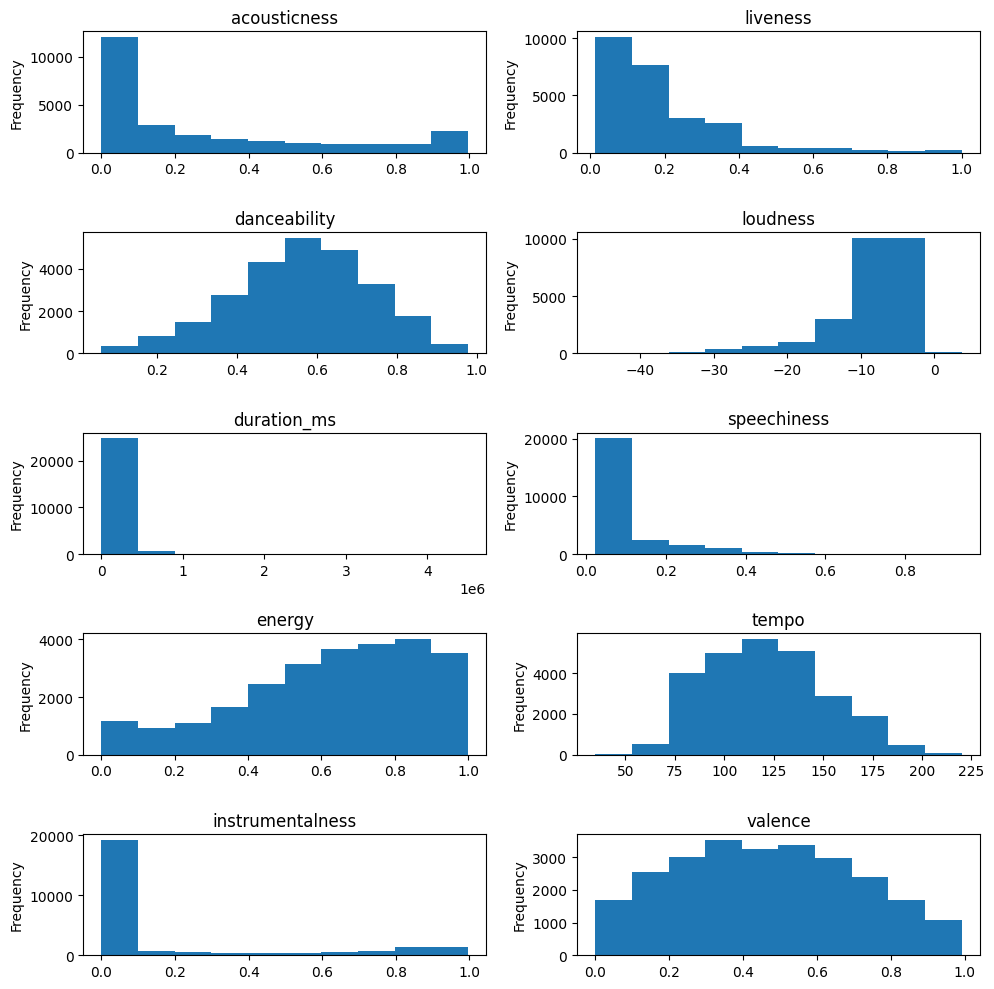

In [26]:
# Гистограма факторов на всем датафрейме
fig, axes = plt.subplots(5, 2, figsize=(10, 10))

# Перебираем каждый столбец и строим гистограмму на соответствующем подграфике
for i, col in enumerate(numerical):
    x = i % 5
    y = i // 5
    df[col].plot.hist(ax=axes[x, y])
    axes[x, y].set_title(col)

plt.tight_layout()
plt.show()

acousticness


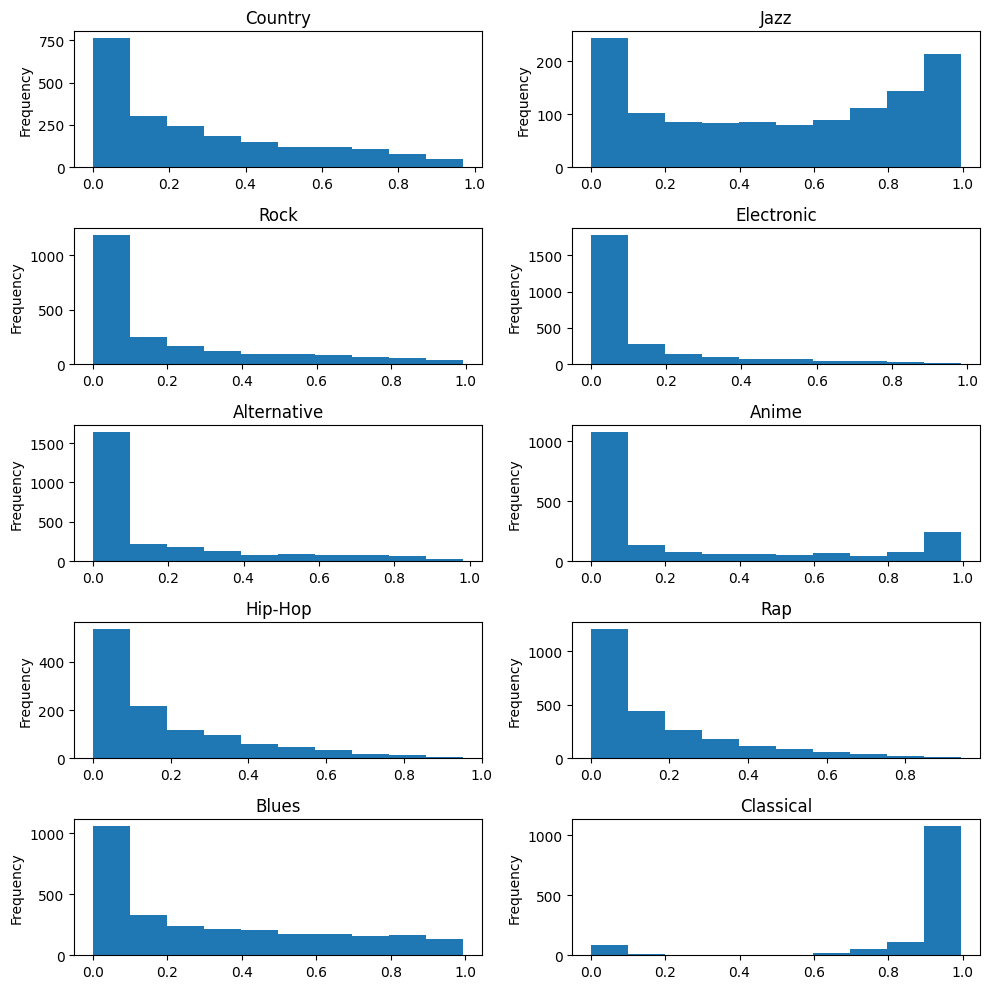

-------------------------------------------------------------
danceability


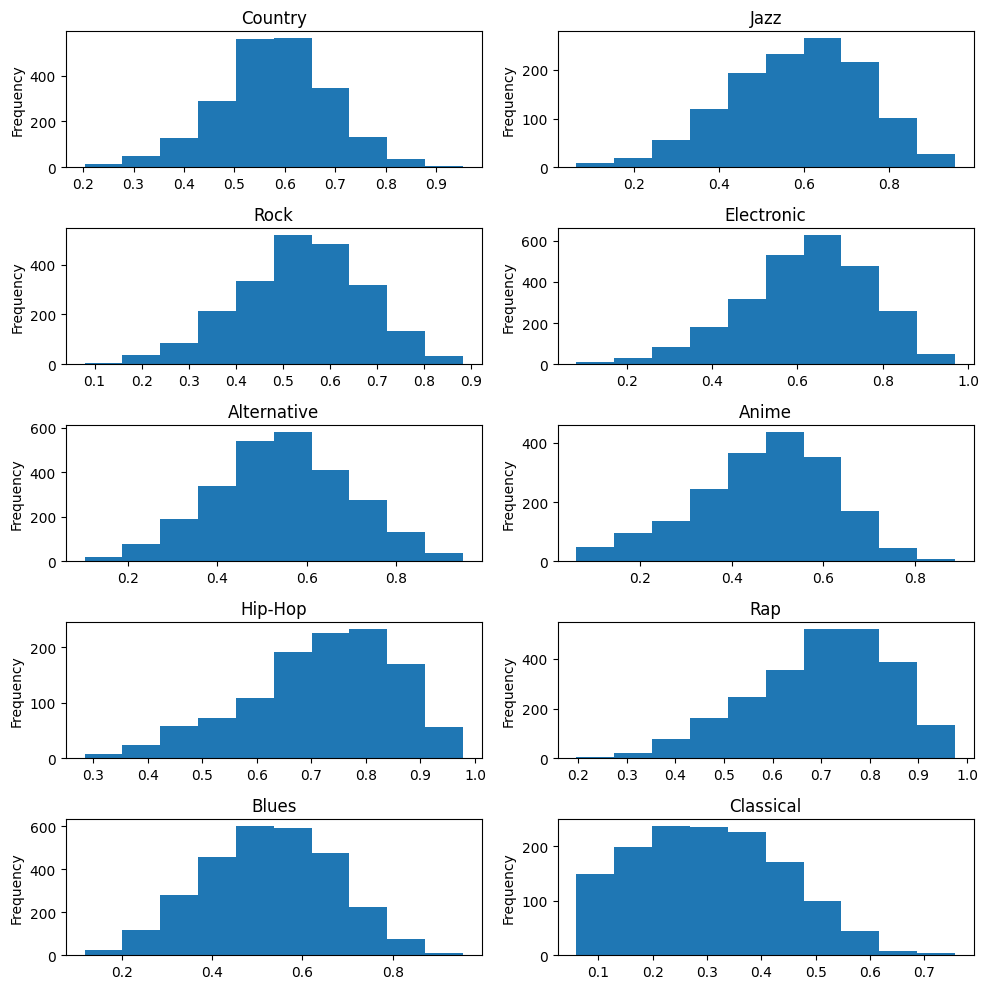

-------------------------------------------------------------
duration_ms


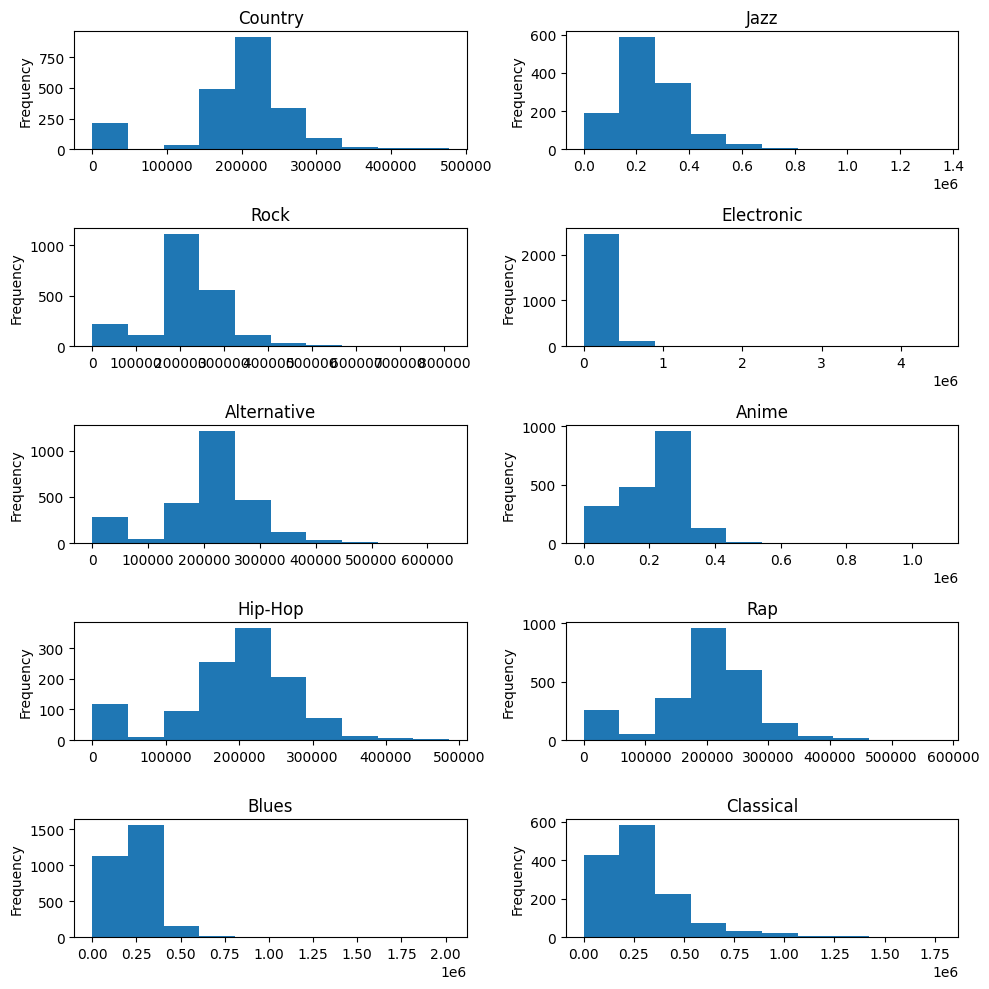

-------------------------------------------------------------
energy


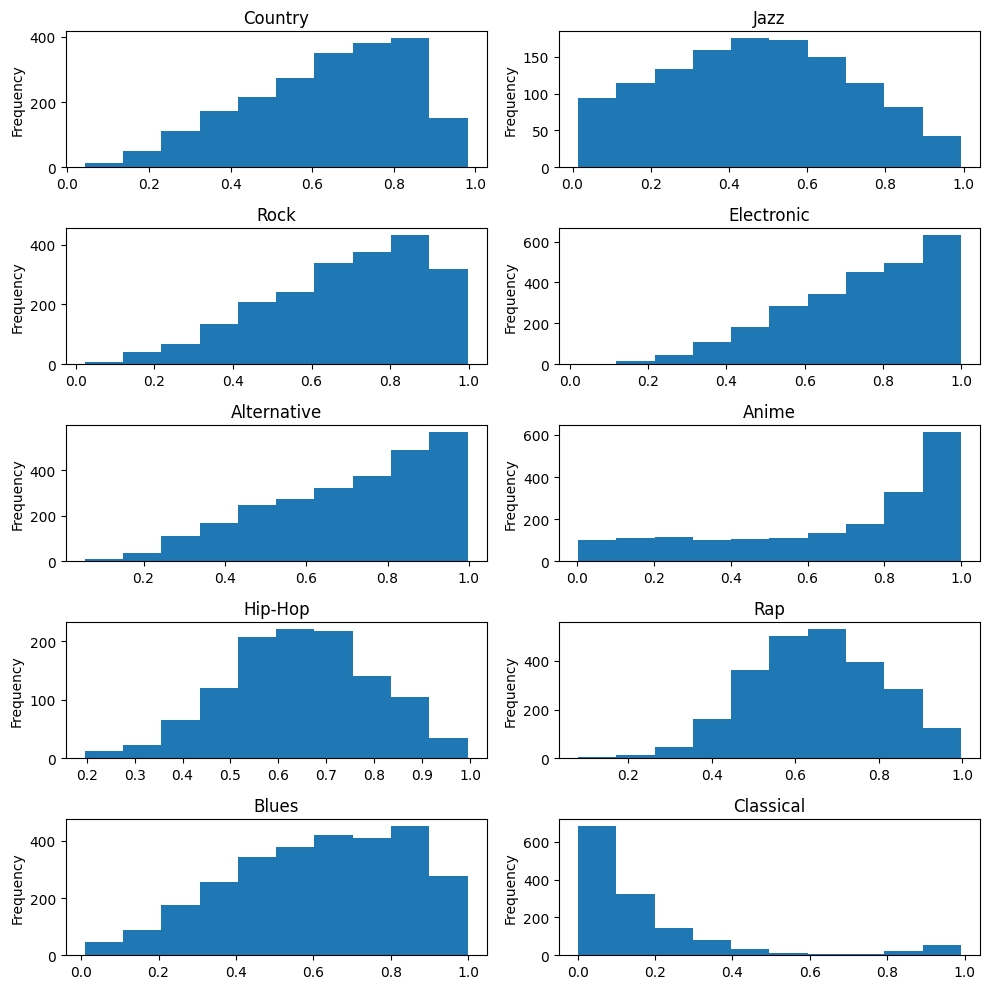

-------------------------------------------------------------
instrumentalness


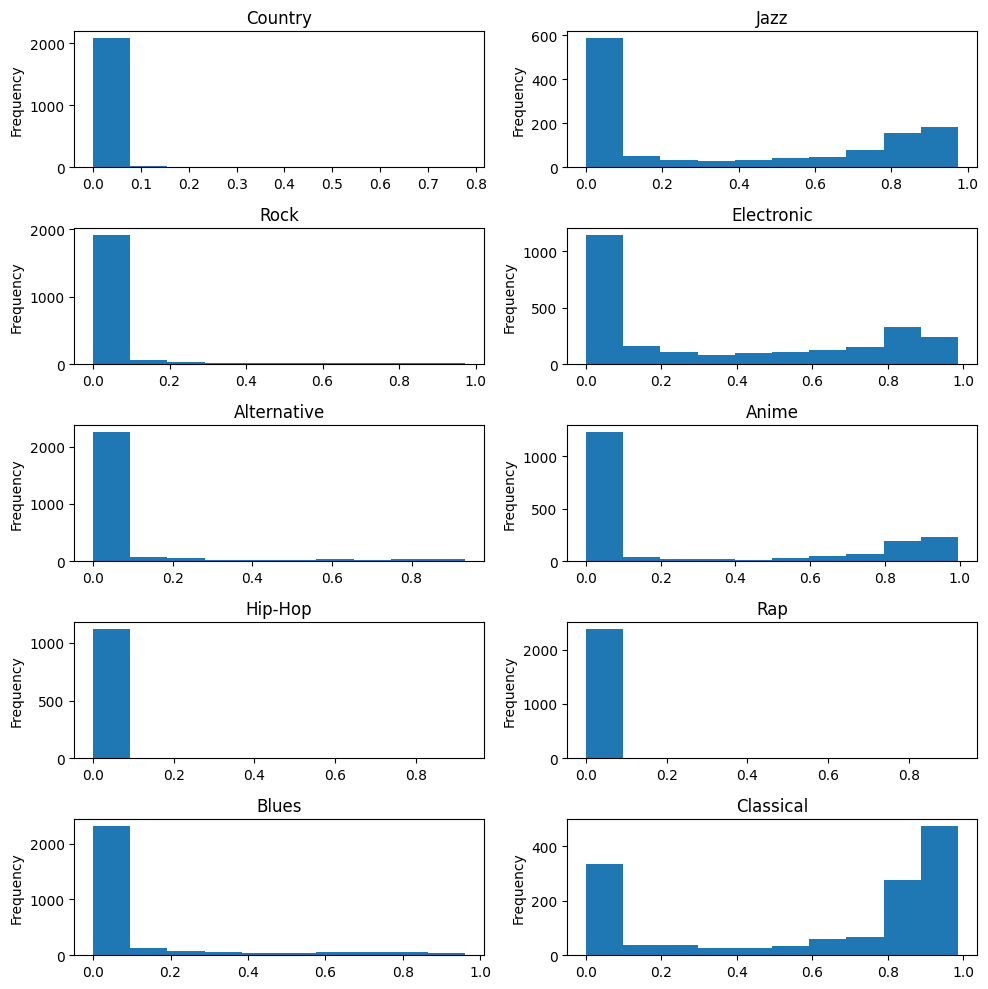

-------------------------------------------------------------
liveness


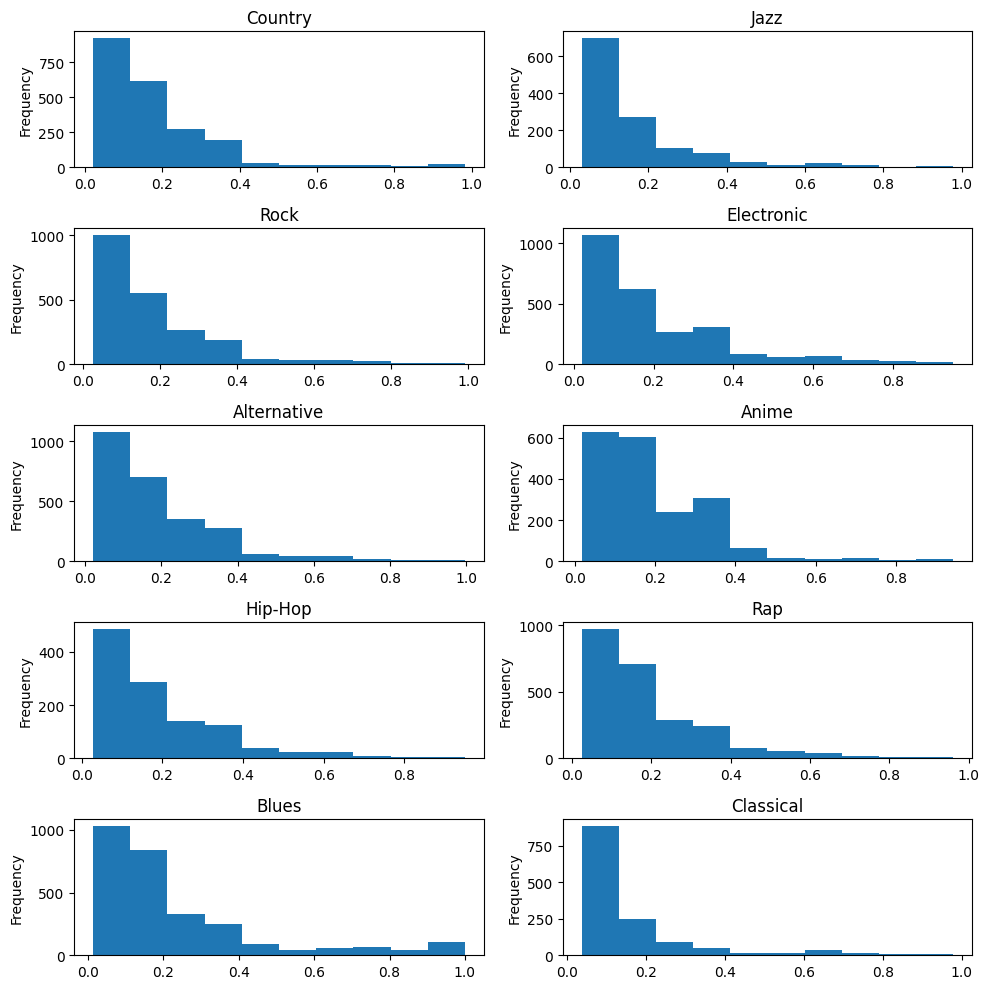

-------------------------------------------------------------
loudness


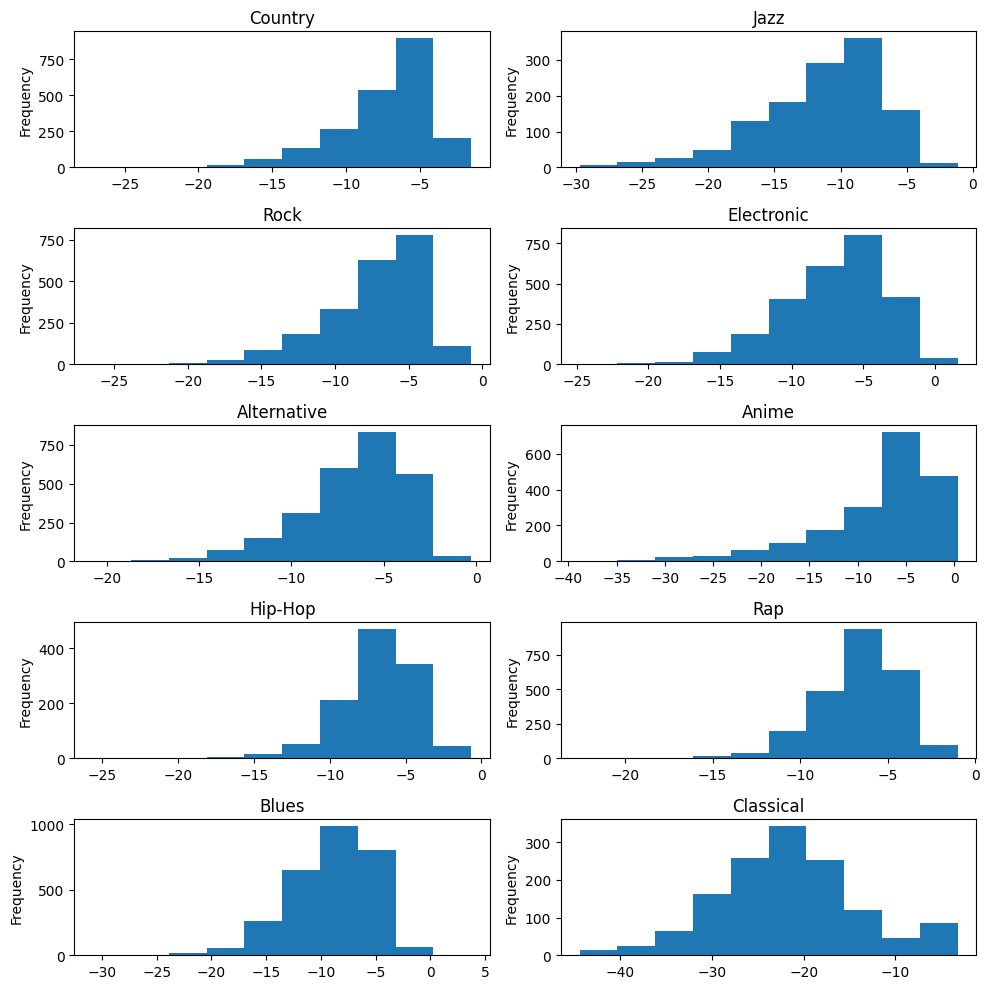

-------------------------------------------------------------
speechiness


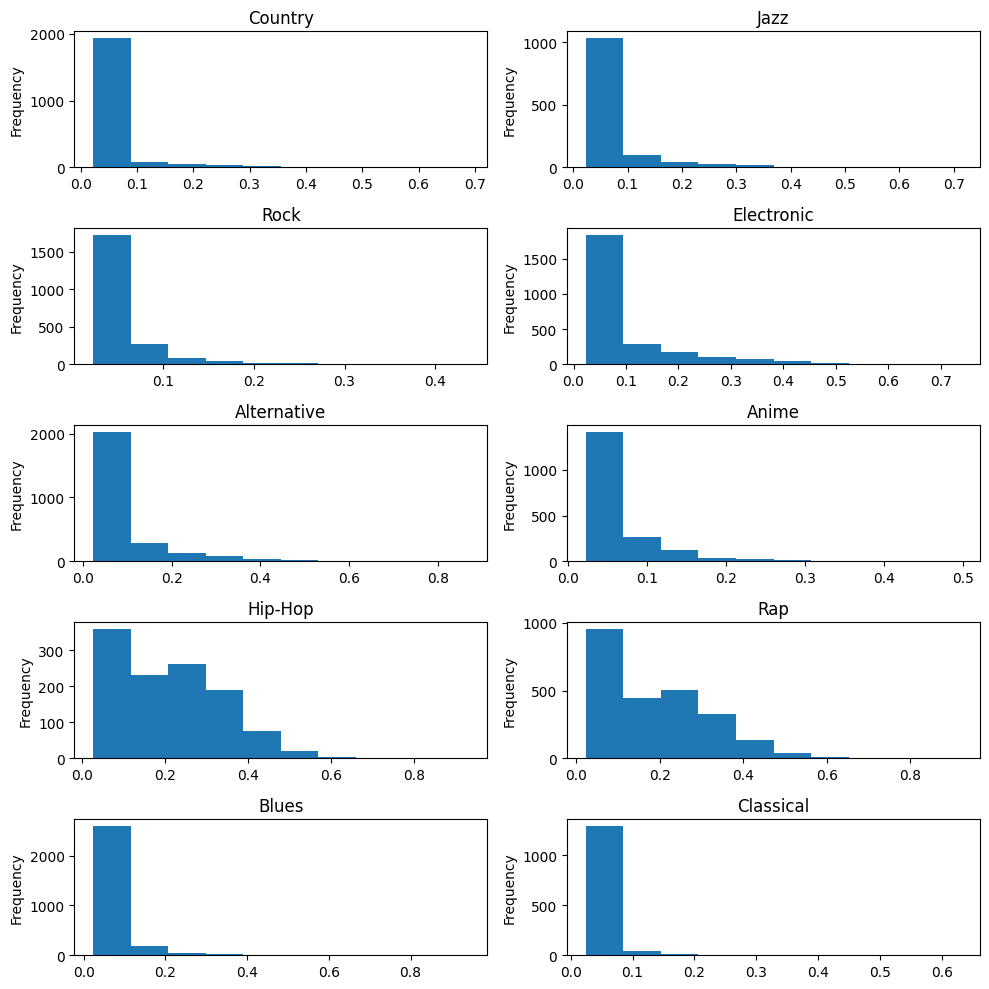

-------------------------------------------------------------
tempo


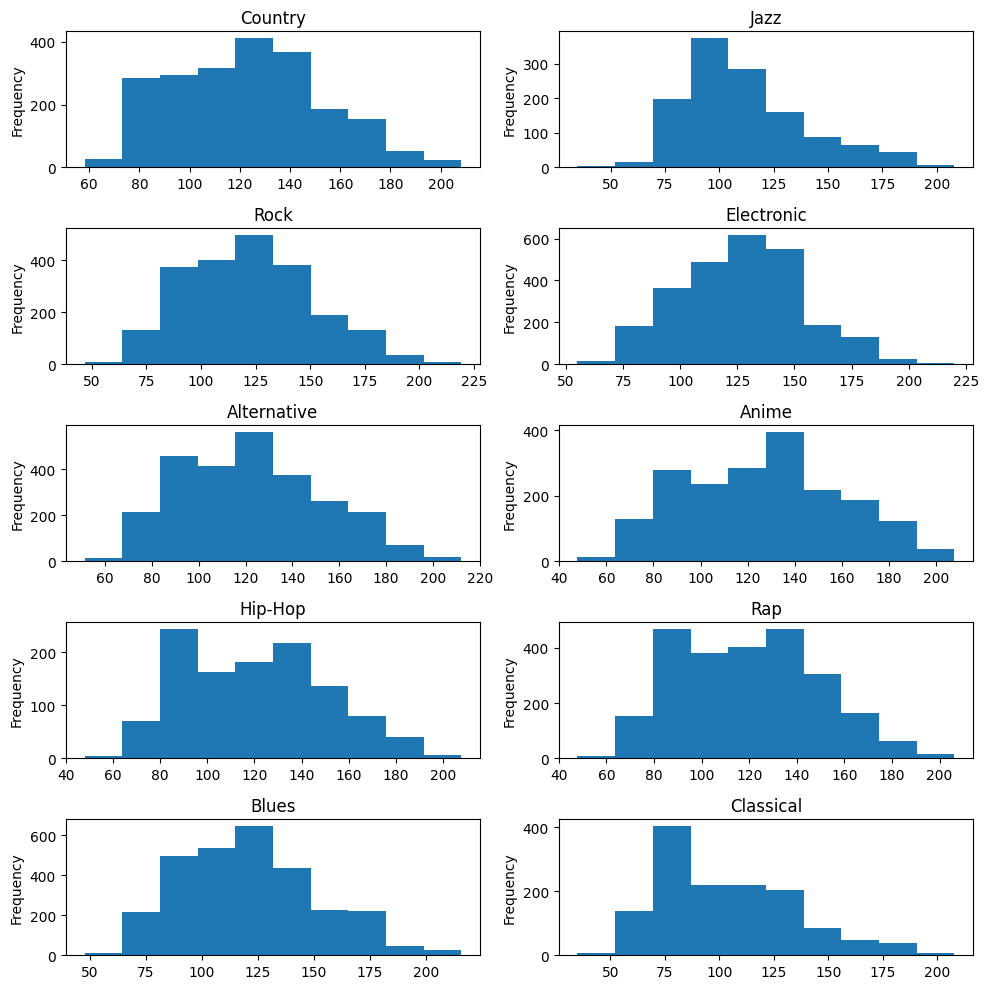

-------------------------------------------------------------
valence


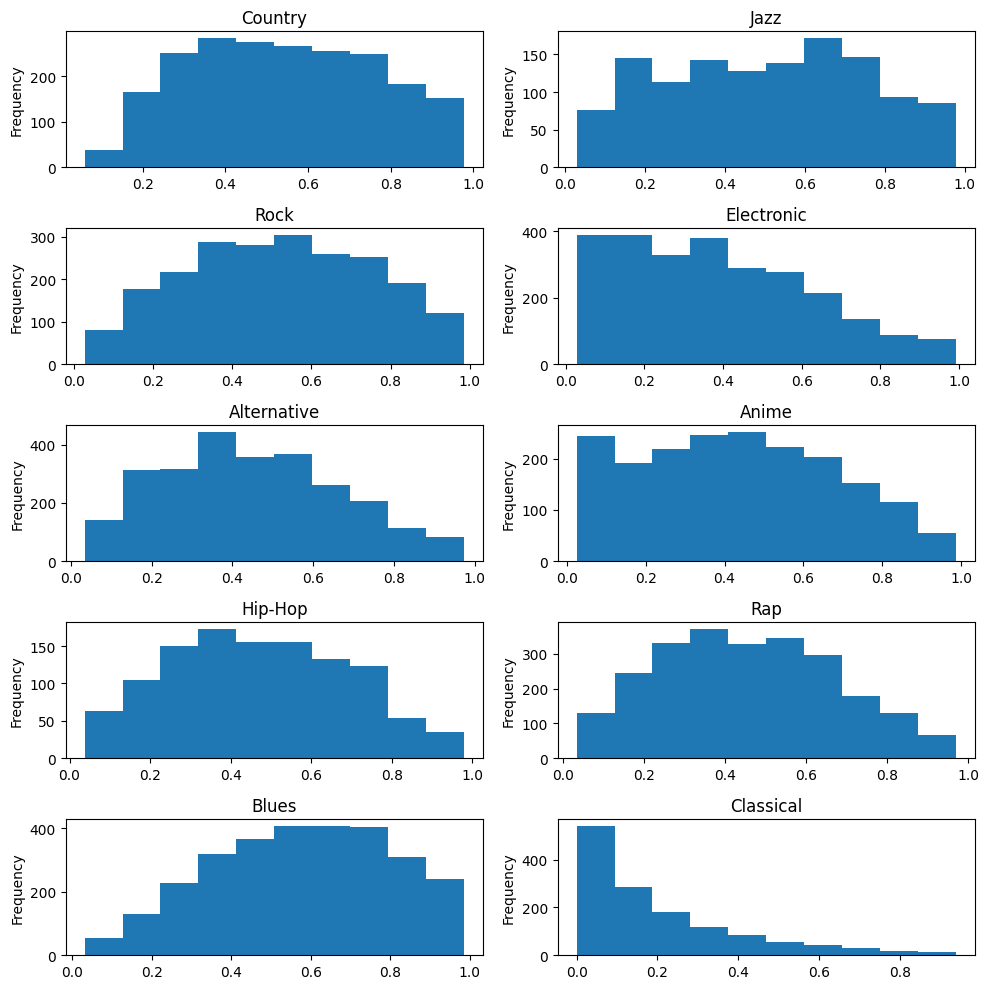

-------------------------------------------------------------


In [27]:
# Гистограма факторов в разрезе жанров

for col_name in numerical:
  print(col_name)
  df_check = df[['music_genre', f'{col_name}']]
  df_check = df_check[df_check['music_genre'].isna()==False]

  # Определяем размеры графиков
  fig, axes = plt.subplots(5, 2, figsize=(10, 10))

  # Перебираем каждый музыкальный жанр и строим гистограмму длительности песни
  unique_genres = df_check['music_genre'].unique()
  for i, genre in enumerate(unique_genres):
      row = i % 5
      col = i // 5
      genre_data = df_check[df_check['music_genre'] == genre][f'{col_name}']
      genre_data.plot.hist(ax=axes[row, col])
      axes[row, col].set_title(genre)

  plt.tight_layout()
  plt.show()
  print('-------------------------------------------------------------')

In [28]:
describe

,index,count,mean,std,min,1%,25%,50%,75%,95%,max,share NA
0,instance_id,25493.0,55907.846625,20709.142078,20011.00000,20723.920000,38043.0000,55872.000000,73862.00000,88200.4000,91758.000,0.000000
1,acousticness,25493.0,0.275092,0.321841,0.00000,0.000028,0.0154,0.120000,0.46900,0.9650,0.996,0.000000
2,danceability,25493.0,0.561964,0.171616,0.05960,0.132920,0.4510,0.570000,0.68200,0.8340,0.978,0.000000
3,duration_ms,25493.0,219779.775036,124592.488715,-1.00000,-1.000000,176800.0000,219187.000000,265714.00000,393420.8000,4497994.000,0.000000
4,energy,25493.0,0.624627,0.251354,0.00101,0.018300,0.4690,0.665000,0.83000,0.9570,0.999,0.000000
5,instrumentalness,25493.0,0.161031,0.307599,0.00000,0.000000,0.0000,0.000146,0.08590,0.8980,0.996,0.000000
6,liveness,25493.0,0.198417,0.166639,0.01360,0.041900,0.0972,0.129000,0.25200,0.5720,1.000,0.000000
7,loudness,25493.0,-8.568437,5.524072,-46.12200,-29.675800,-10.2480,-7.066000,-5.06300,-3.0210,3.744,0.000000
8,speechiness,25493.0,0.091625,0.098218,0.02230,0.025400,0.0356,0.049000,0.09580,0.3160,0.942,0.000000
9,tempo,24930.0,121.003213,30.317889,34.76500,66.938480,95.9685,120.019000,141.96375,174.0841,220.041,0.022084


In [29]:
df[df['duration_ms'] == 4497994]

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
20117,Late Night Tales: Bonobo,0.528,0.408,4497994.0,0.436,0.0995,E,0.198,-11.497,Minor,0.164,76.868,0.0778,Electronic


In [30]:
len(df[(df['duration_ms'] == -1) & (df['music_genre'].isna()==False)])

2009

In [31]:
# Замена значения -1 в поле duration_ms средним значением по жанру

genre_mean_duration = df[df['duration_ms'] != -1].groupby('music_genre')['duration_ms'].mean()

genre_mean_duration
# Замена значений -1 на среднее значение для соответствующих жанров
for genre in genre_mean_duration.index:
    mean_duration = genre_mean_duration[genre]
    df.loc[(df['duration_ms'] == -1) & (df['music_genre'] == genre), 'duration_ms'] = mean_duration

In [32]:
df.loc[(df['duration_ms'] == -1) & (df['music_genre'].isna()== True), 'duration_ms'] = df['duration_ms'].mean()

In [33]:
len(df[(df['duration_ms'] == -1)])

0

## Работа с признаками

In [34]:
from collections import Counter

In [35]:
# Разделяем текст на слова и считаем их частоту
words = ' '.join(df['track_name']).split()
word_counts = Counter(words)

# Выводим наиболее встречающиеся слова
most_common_words = word_counts.most_common(100)
print("Самые часто встречающиеся слова:")
word_list = []
for word, count in most_common_words:
  word_list.append(word)
  print(f"{word}: {count}")
print(word_list)

Самые часто встречающиеся слова:
-: 2838
The: 1927
(feat.: 1249
You: 1116
I: 954
the: 897
Me: 859
in: 802
My: 669
Love: 619
In: 604
A: 592
of: 567
It: 550
No.: 544
Live: 478
&: 477
Remastered: 465
To: 440
Remix: 438
Version: 431
On: 420
Op.: 408
Of: 396
a: 351
to: 324
and: 313
All: 305
No: 303
Your: 296
Up: 295
Is: 283
Don't: 279
Down: 260
for: 245
Major,: 233
Be: 228
Time: 221
Like: 217
For: 206
One: 202
Go: 195
I'm: 193
Good: 193
And: 190
Get: 185
We: 183
/: 183
This: 180
Man: 180
Remaster: 178
Allegro: 172
That: 170
Piano: 169
From: 168
2: 166
Way: 163
Back: 162
on: 161
Do: 160
Out: 159
Life: 154
Song: 154
With: 153
Minor,: 152
Blues: 149
Night: 149
Home: 147
What: 147
Let: 147
Girl: 147
Got: 144
at: 144
1: 139
Act: 137
Mix: 135
Symphony: 133
Blue: 132
I.: 131
When: 130
World: 129
II.: 128
Day: 125
Little: 124
D: 124
Never: 122
Heart: 122
Just: 122
Know: 121
New: 120
Concerto: 119
K.: 117
Take: 117
If: 115
Come: 115
Away: 115
Baby: 113
Single: 113
BWV: 113
C: 112
['-', 'The', '(feat

In [36]:
df['music_genre'].unique()

array([nan, 'Country', 'Rock', 'Alternative', 'Hip-Hop', 'Blues', 'Jazz',
       'Electronic', 'Anime', 'Rap', 'Classical'], dtype=object)

In [37]:
music_genres = ['Country', 'Rock', 'Alternative', 'Hip-Hop', 'Blues', 'Jazz',
       'Electronic', 'Anime', 'Rap', 'Classical']

for genre in music_genres:
  df_genre = df[df['music_genre'] == genre]

  words = ' '.join(df_genre['track_name']).split()
  word_counts = Counter(words)

  word_list = []  #list(word_counts.keys())

  # Выводим наиболее встречающиеся слова
  most_common_words = word_counts.most_common(30)
  print(f"Самые часто встречающиеся слова в жанре {genre}:")
  for word, count in most_common_words:
      word_list.append(word)
      # print(f"{word}: {count}")
  print(word_list)

Самые часто встречающиеся слова в жанре Country:
['You', '-', 'The', 'I', 'Me', 'the', 'My', 'It', 'Love', 'On', 'A', 'In', 'To', '(feat.', 'a', 'Of', "Don't", 'Version', 'to', 'Live', 'That', 'All', 'Country', 'This', 'Like', 'of', 'Be', 'When', 'and', 'in']
Самые часто встречающиеся слова в жанре Rock:
['-', 'The', 'You', 'Remastered', 'I', 'Me', 'the', 'Love', 'My', 'Version', 'In', 'It', 'Of', 'A', 'Remaster', 'To', 'On', 'of', 'Your', 'a', 'to', 'in', 'For', 'Live', 'Be', 'Is', 'Man', 'Down', "Don't", 'All']
Самые часто встречающиеся слова в жанре Alternative:
['The', '-', '(feat.', 'You', 'I', 'the', 'Me', 'My', 'It', 'In', 'of', 'Of', 'A', 'Your', 'Love', 'Live', '&', 'To', 'On', 'to', 'All', 'Be', 'Is', 'and', 'Up', 'Go', 'This', 'No', "Don't", 'Like']
Самые часто встречающиеся слова в жанре Hip-Hop:
['(feat.', 'The', '-', '&', 'Me', 'It', 'I', 'My', 'A', 'Up', 'You', 'On', 'To', 'Lil', 'the', 'In', 'No', 'Love', "Don't", 'Remix', 'Go', 'All', 'Way', 'Down', 'Right', 'Bad', 'of

In [38]:
classical = ['No.', 'Op.', 'Major,', 'Allegro', 'Minor,', 'Symphony', 'Act', 'I.', 'Piano', 'II.', 'BWV', 'Concerto', 'K.', 'Sonata', 'III.', 'Andante', 'Prelude']
electronic = ['Remix', 'Remix)', 'Mix', 'Edit', 'Original']
anime = ['Fantasy', '(From', 'Version', 'Theme', '"Final', 'Piano']
feat= ['(feat.']
love = ['Love', 'love', 'you', 'You', 'Me', 'me', 'Heart', 'heart', 'your', 'Your', 'My', 'my']

list_of_lists = [classical, electronic, love, anime, feat] #
col_name = ['classical', 'electronic', 'love', 'anime', 'feat'] #

# df2 = df.copy()
for i in range(len(list_of_lists)):
  words_to_check = list_of_lists[i]
  df[f'{col_name[i]}_flag'] = df['track_name'].apply(lambda x: 1 if any(word in x for word in words_to_check) else 0)


In [39]:
# df3=df2[(df2['music_genre'].isna()== False) & (df2['love_flag'] == 1)] #(df2['music_genre'] == 'Anime') &
# df3#.music_genre.value_counts()

track_name - название трека

acousticness - акустичность

danceability - танцевальность

duration_ms -продолжительность в милисекундах

energy - энергичность

instrumentalness - инструментальность

key - тональность

liveness - привлекательность

loudness - громкость

mode - наклонение

speechiness - выразительность

tempo - темп

obtained_date - дата загрузки в сервис

valence - привлекательность произведения для пользователей сервиса

music_genre - музыкальный жанр


In [40]:
df.head()

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,classical_flag,electronic_flag,love_flag,anime_flag,feat_flag
0,Low Class Conspiracy,0.301000,0.757,146213.00000,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,0.895,NaN,0,0,0,0,0
1,The Hunter,0.538000,0.256,240360.00000,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,0.318,NaN,0,0,0,0,0
2,Hate Me Now,0.005830,0.678,284000.00000,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,0.412,NaN,0,0,1,0,0
3,Somebody Ain't You,0.020300,0.592,177354.00000,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,0.614,NaN,0,0,1,0,0
4,Sour Mango,0.000335,0.421,239001.98697,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,0.121,NaN,0,0,0,0,0


In [41]:
df['mode'] = df['mode'].replace(['Major', 'Minor'], [1, 0])
df['duration_m'] = df['duration_ms']/60000
df['energy_dance_score'] = df['energy'] + df['danceability']
df['sound_intensity'] = df['loudness'] * df['tempo']
df['combined_liveness_valence'] = df['liveness'] + df['valence']
df['acoustic_instrumental_factor'] = df['acousticness'] * df['instrumentalness']
df['expressive_complexity'] = df['loudness'] + df['speechiness'] + df['tempo']
df['emotional_expression'] = df['speechiness'] + df['tempo']
df['liveliness'] = (df['liveness'] + df['acousticness'])/2 # df['liveness'] / df['acousticness']
df['mood_score'] = df['valence'] + df['tempo'] + df['loudness']
df['popularity_rating'] = df['danceability']  + df['energy'] + df['duration_ms']
df['all_features_sum'] = df['acousticness'] + df['danceability'] + df['energy'] + df['instrumentalness']\
                         + df['liveness'] + df['loudness'] + df['speechiness'] + df['tempo'] + df['valence']
df['all_features_sum_per_sec'] = (df['acousticness'] + df['danceability'] + df['energy'] + df['instrumentalness']\
                         + df['liveness'] + df['loudness'] + df['speechiness'] + df['tempo'] + df['valence'])/(df['duration_ms']/1000)

In [42]:
df.columns

Index(['track_name', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'music_genre', 'classical_flag',
       'electronic_flag', 'love_flag', 'anime_flag', 'feat_flag', 'duration_m',
       'energy_dance_score', 'sound_intensity', 'combined_liveness_valence',
       'acoustic_instrumental_factor', 'expressive_complexity',
       'emotional_expression', 'liveliness', 'mood_score', 'popularity_rating',
       'all_features_sum', 'all_features_sum_per_sec'],
      dtype='object')

mode


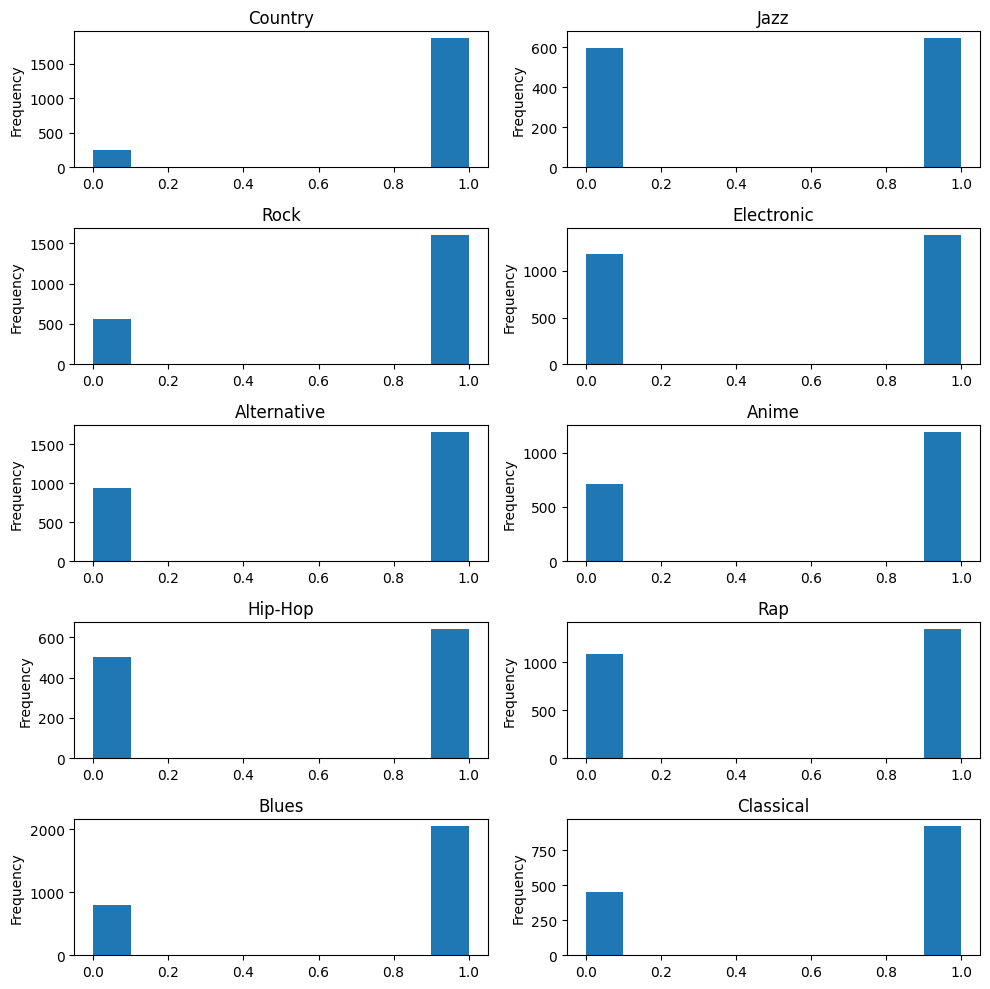

-------------------------------------------------------------
classical_flag


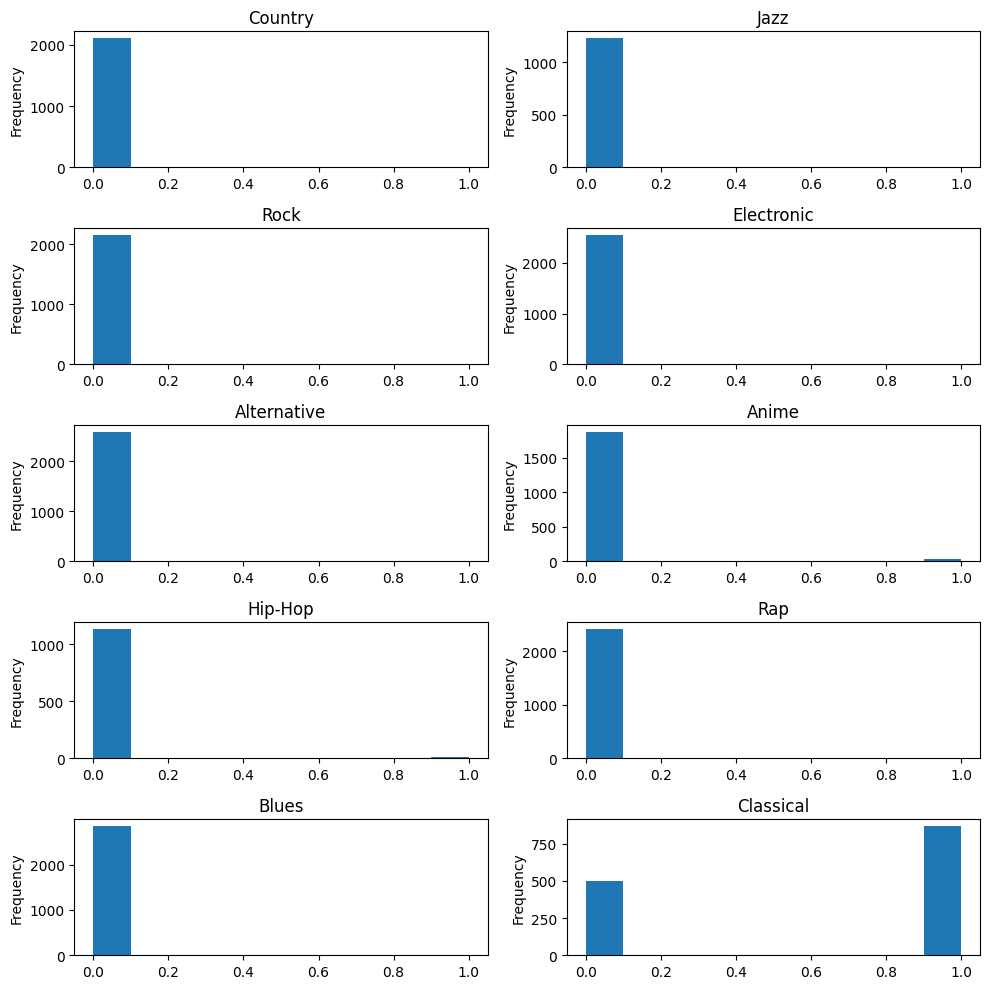

-------------------------------------------------------------
electronic_flag


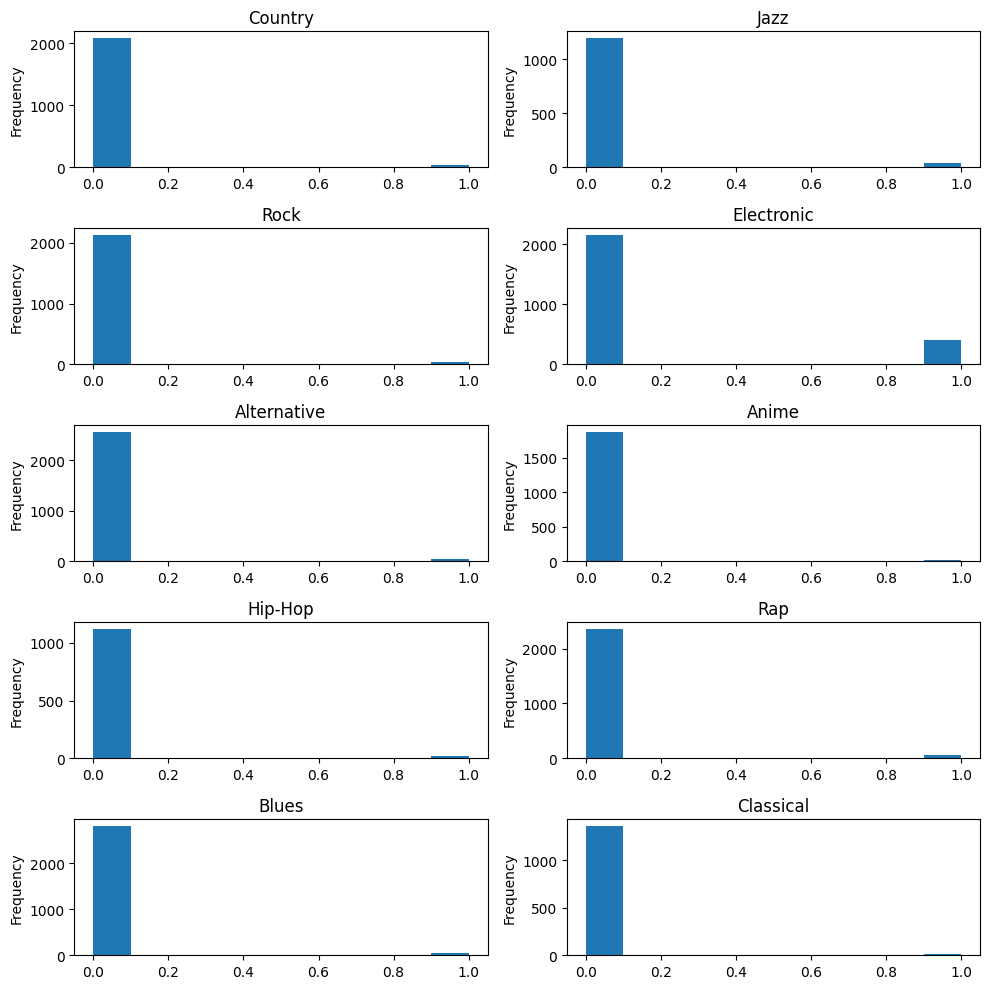

-------------------------------------------------------------
love_flag


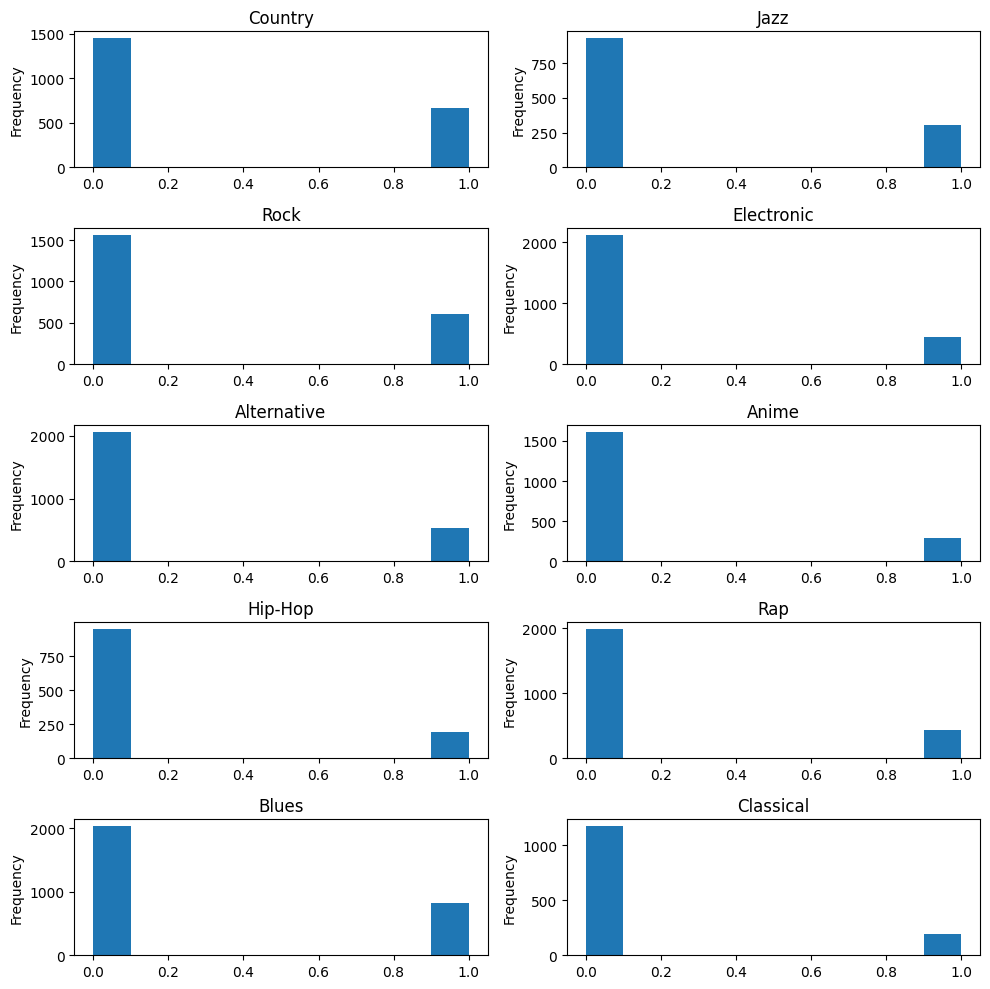

-------------------------------------------------------------
anime_flag


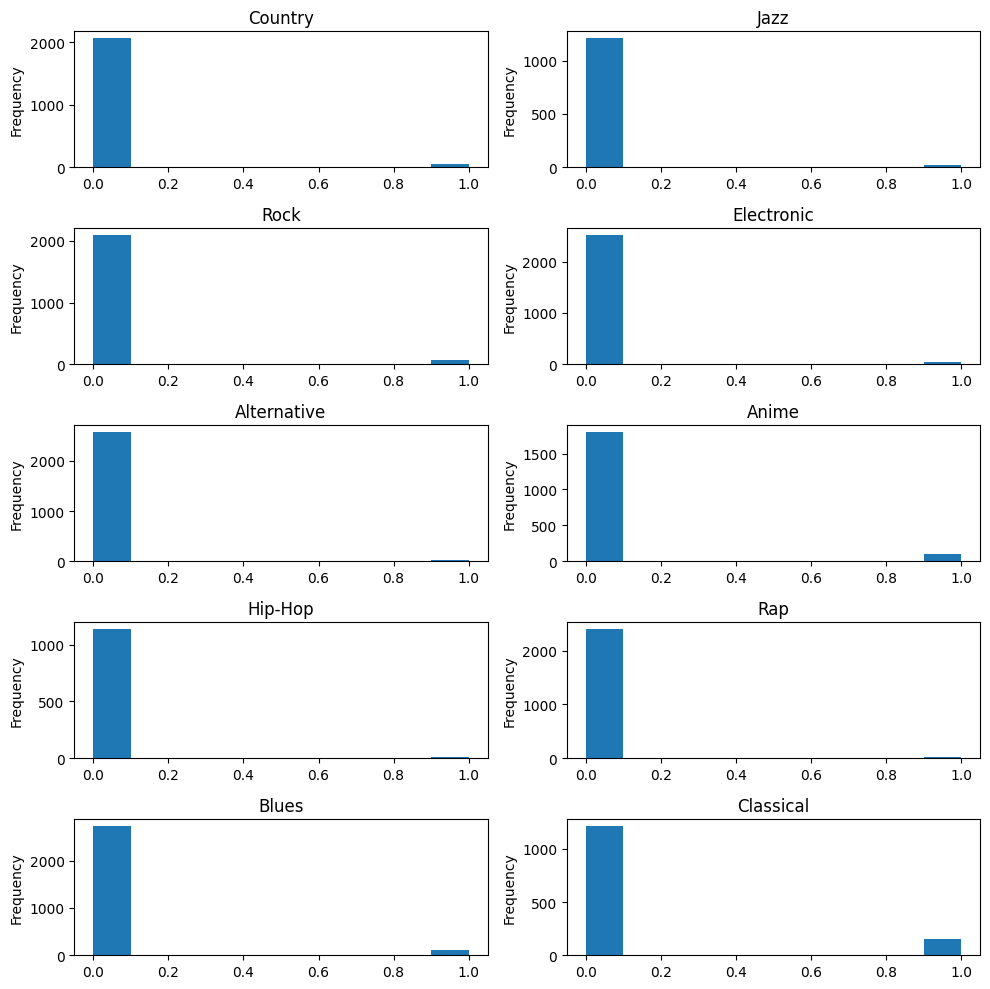

-------------------------------------------------------------
feat_flag


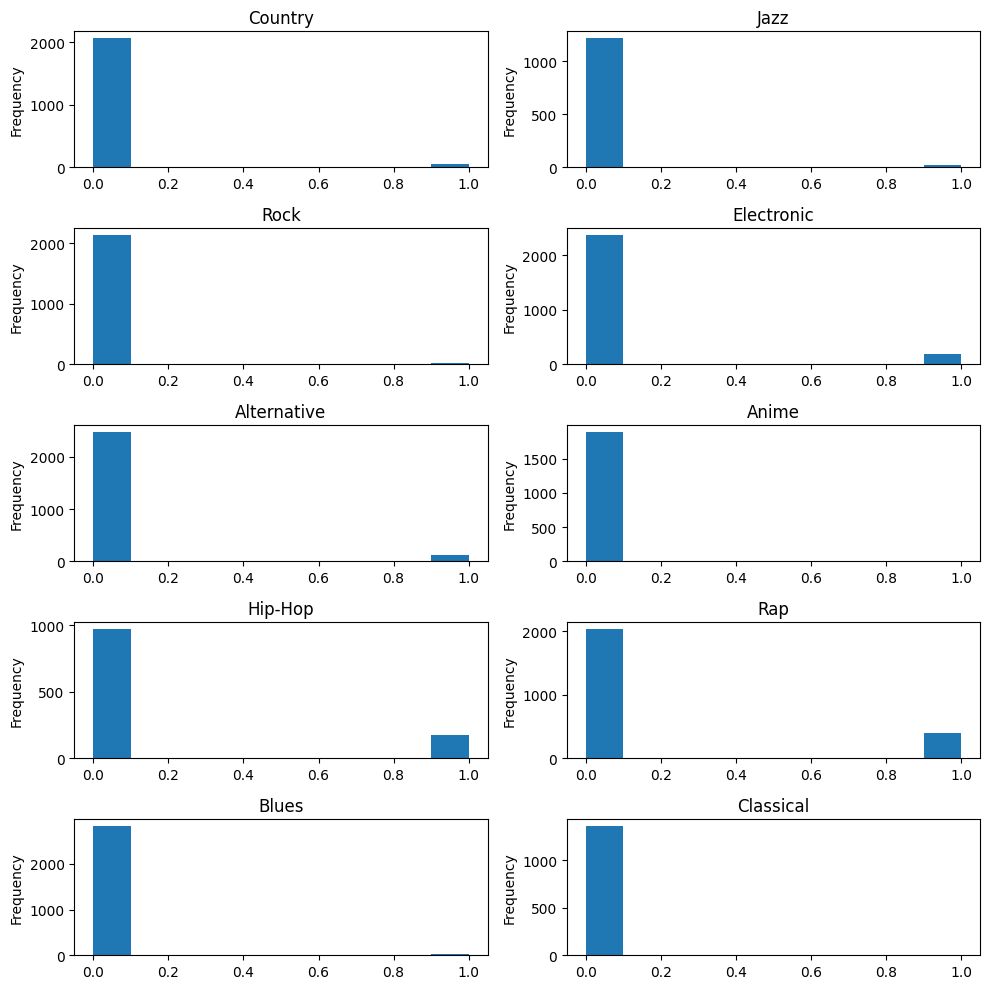

-------------------------------------------------------------
duration_m


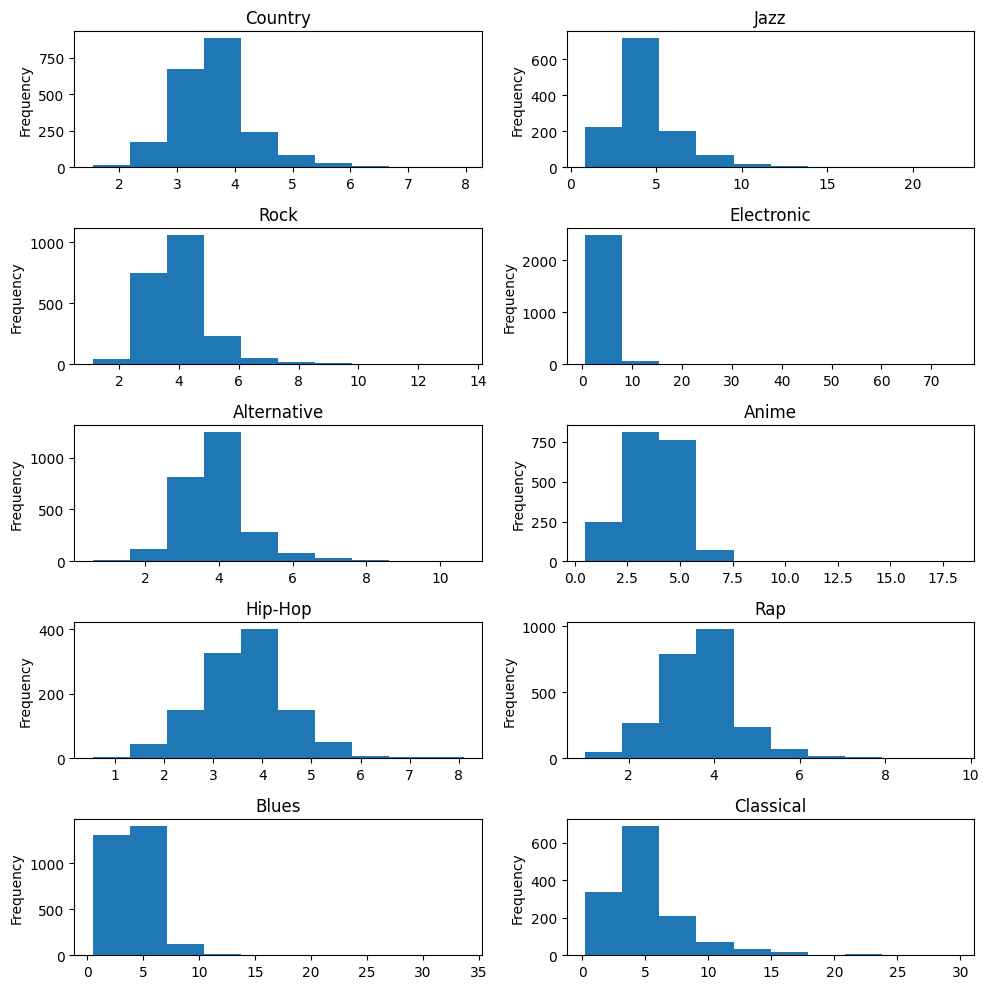

-------------------------------------------------------------
energy_dance_score


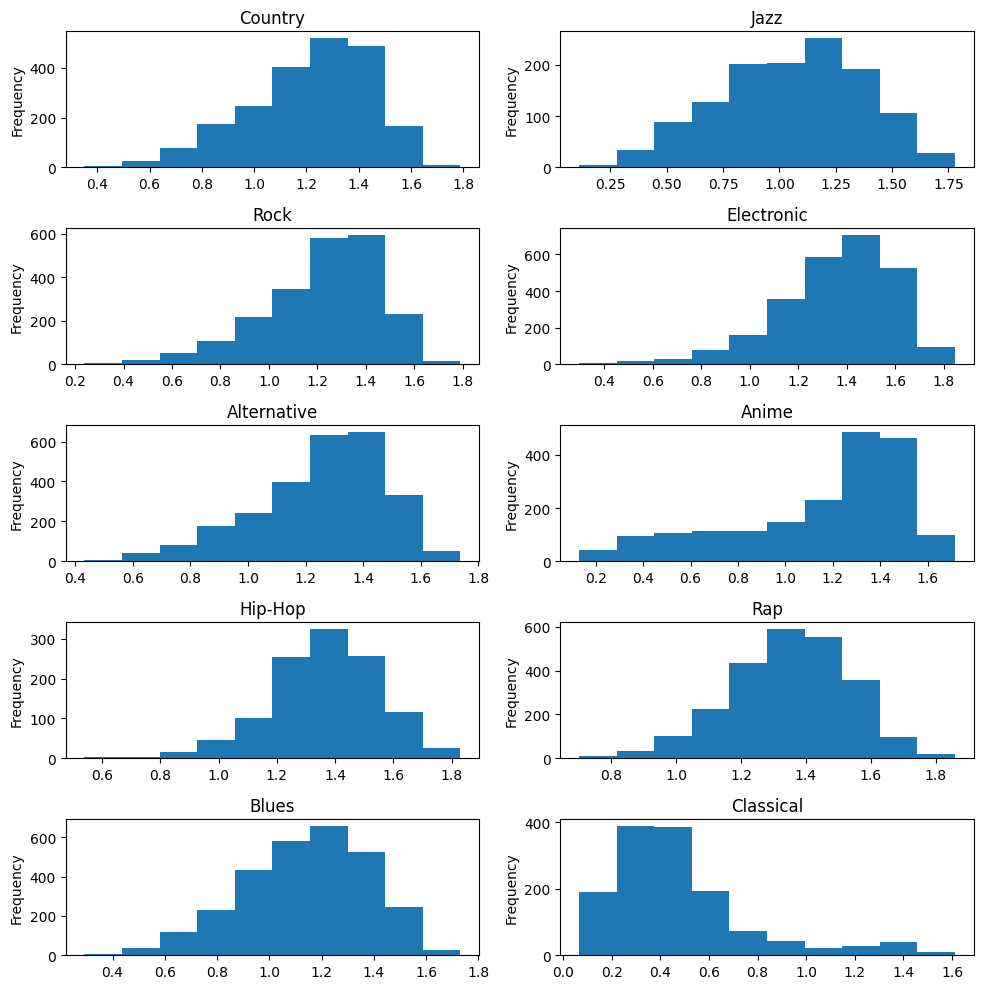

-------------------------------------------------------------
sound_intensity


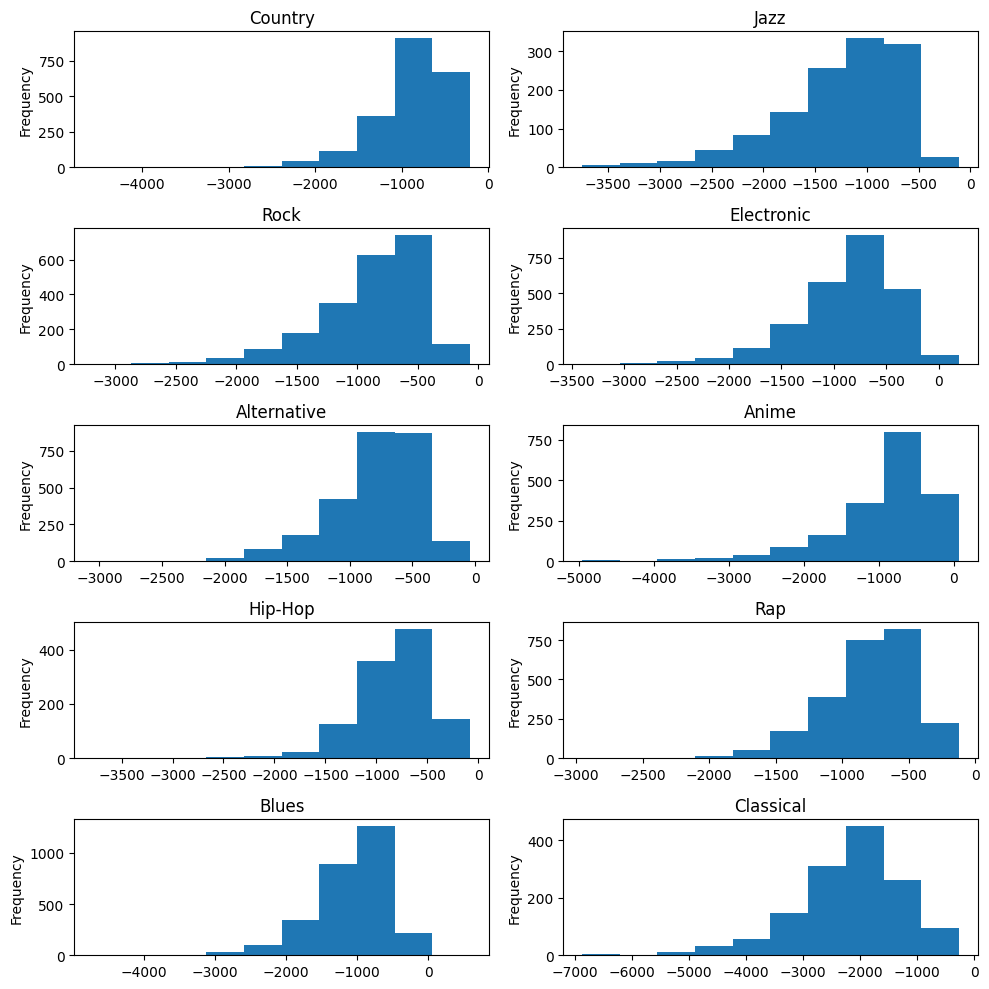

-------------------------------------------------------------
combined_liveness_valence


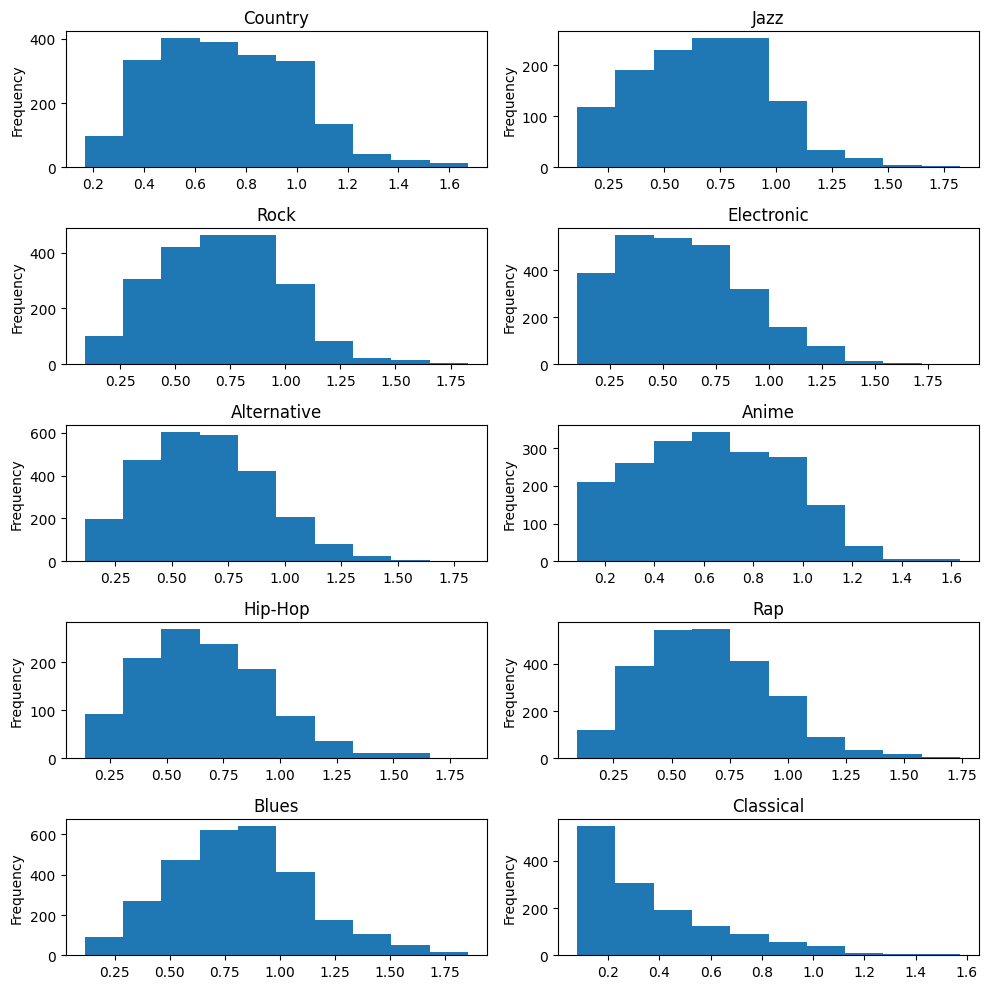

-------------------------------------------------------------
acoustic_instrumental_factor


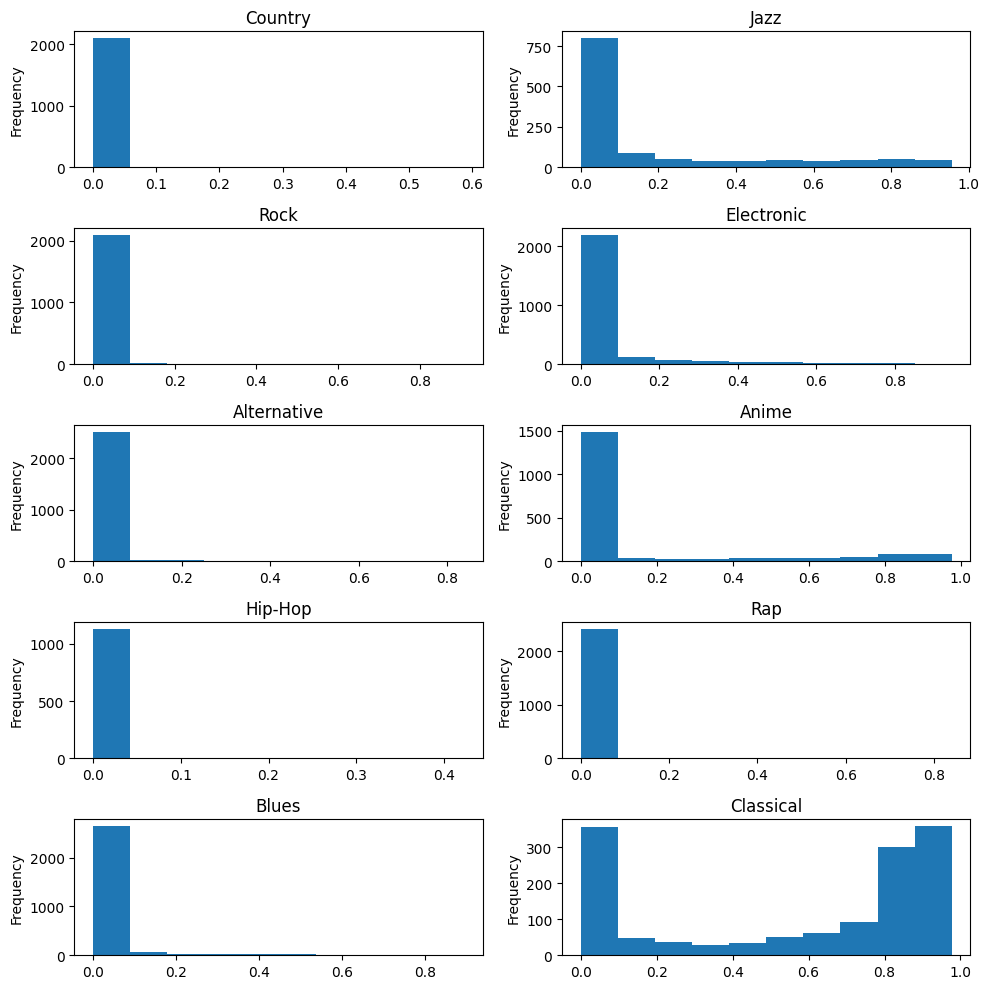

-------------------------------------------------------------
expressive_complexity


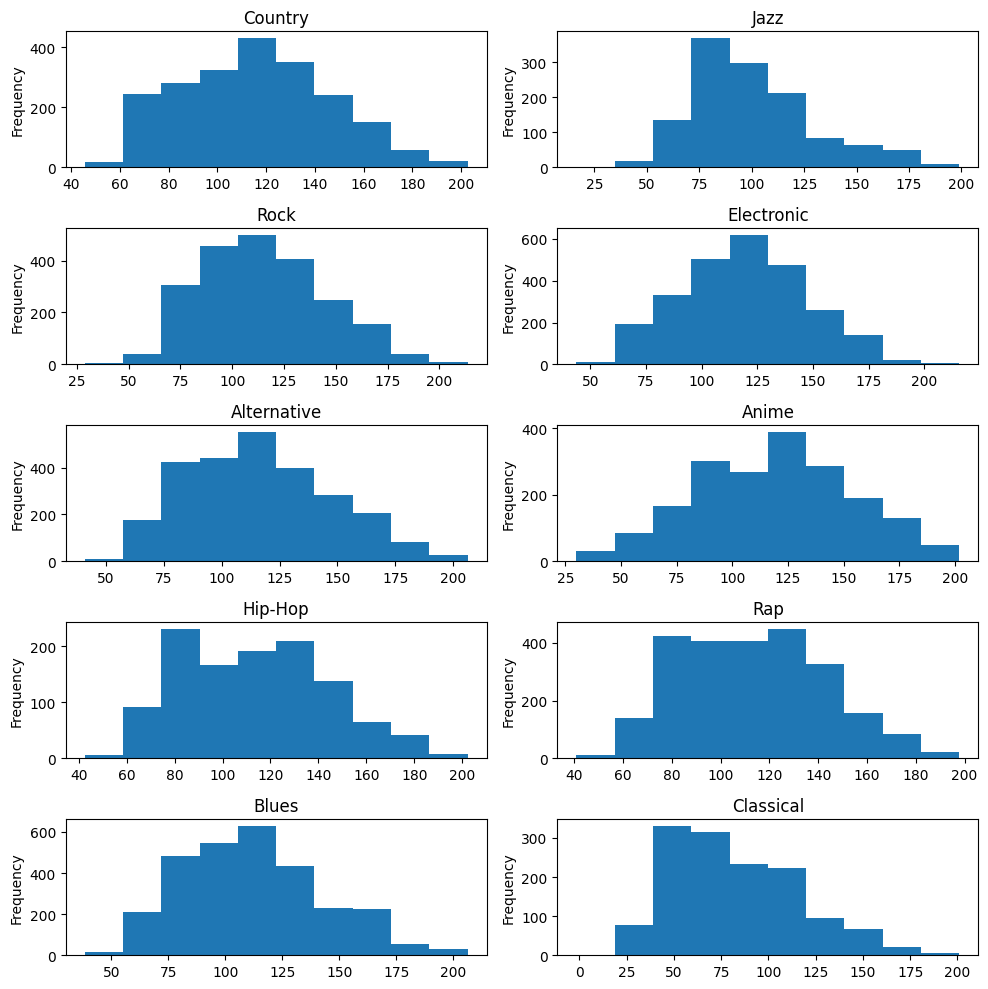

-------------------------------------------------------------
emotional_expression


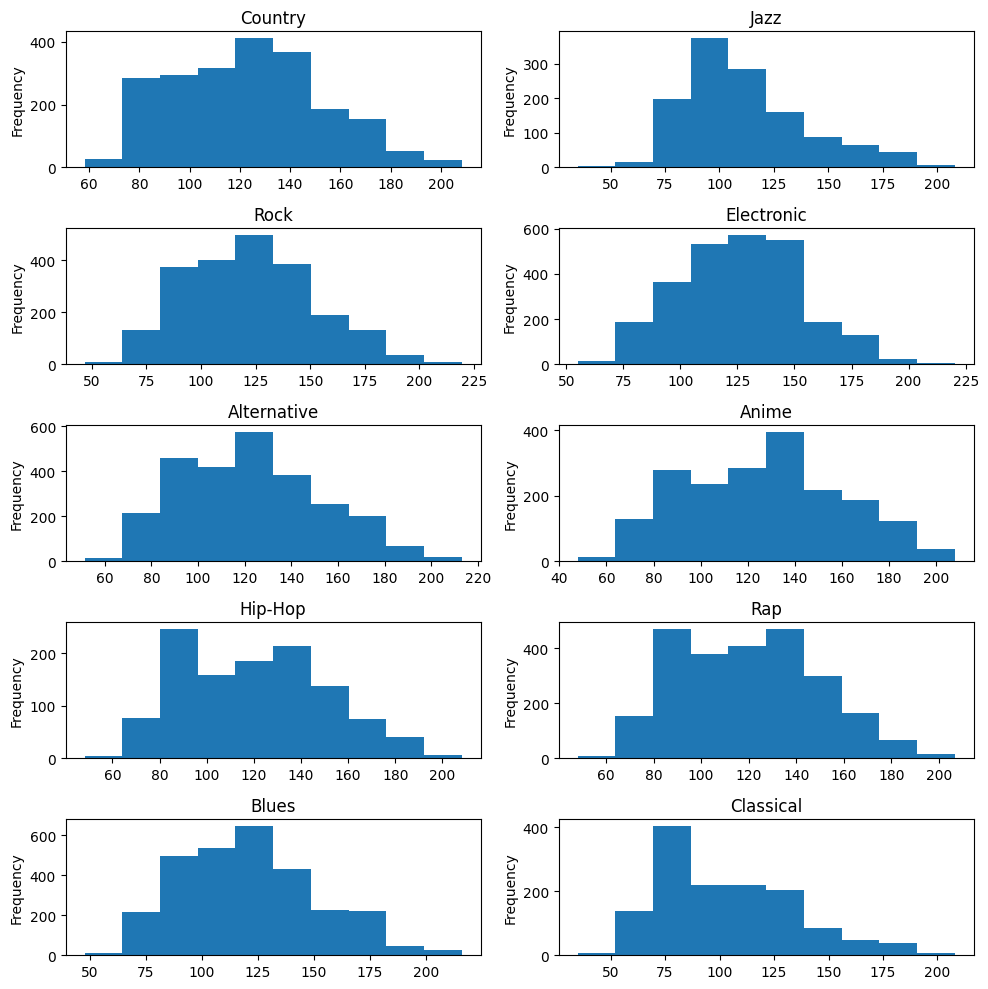

-------------------------------------------------------------
liveliness


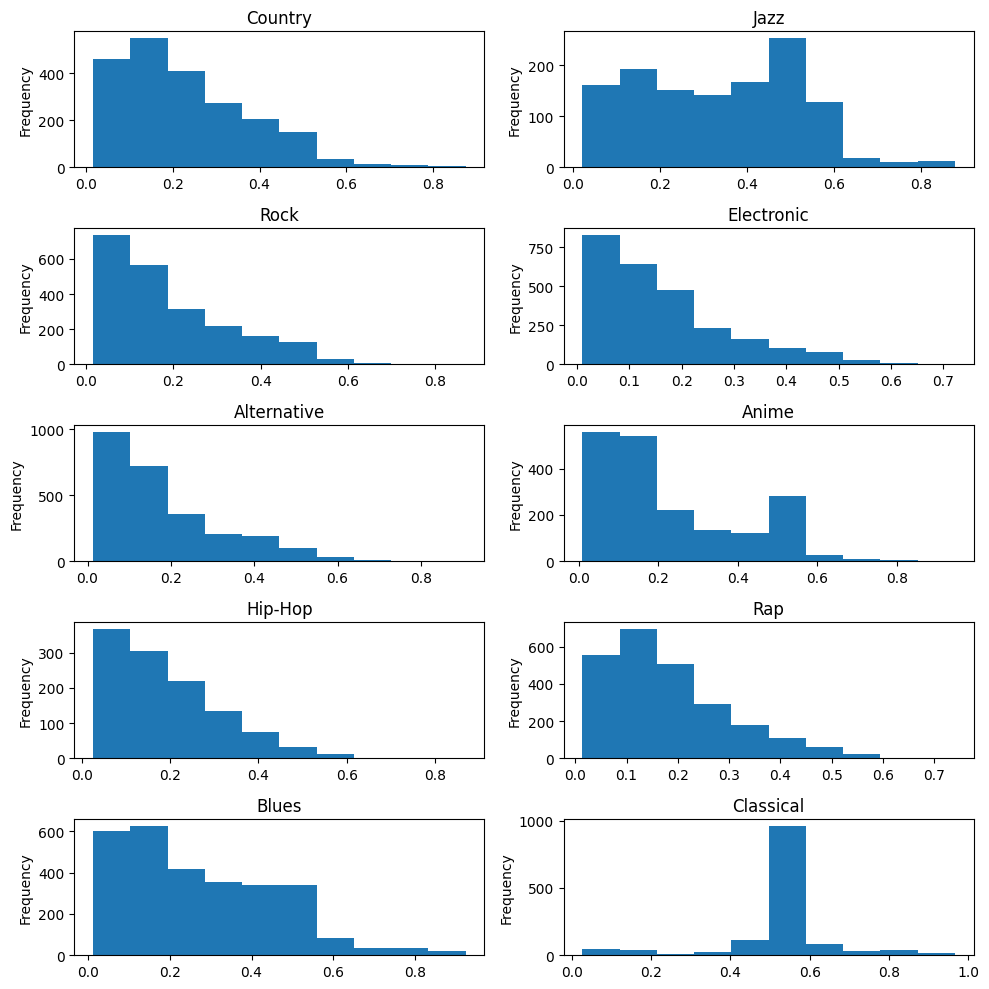

-------------------------------------------------------------
mood_score


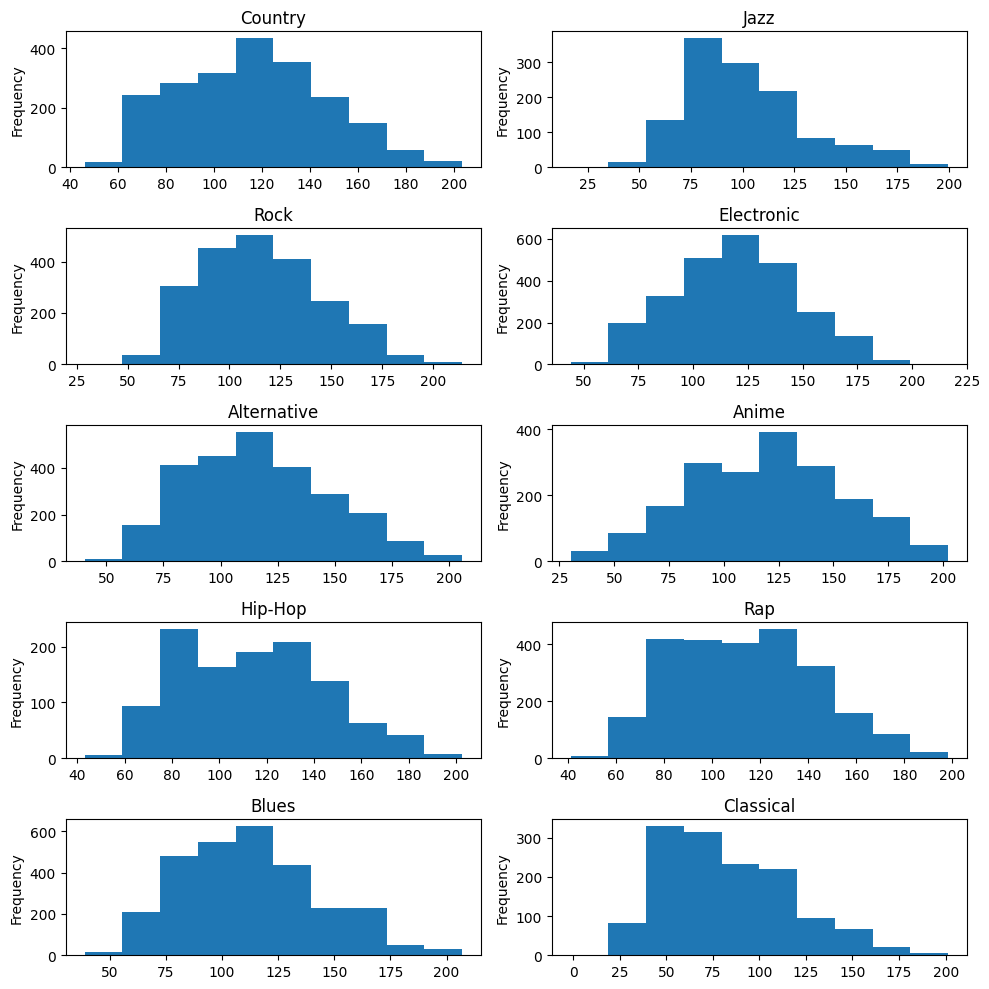

-------------------------------------------------------------
popularity_rating


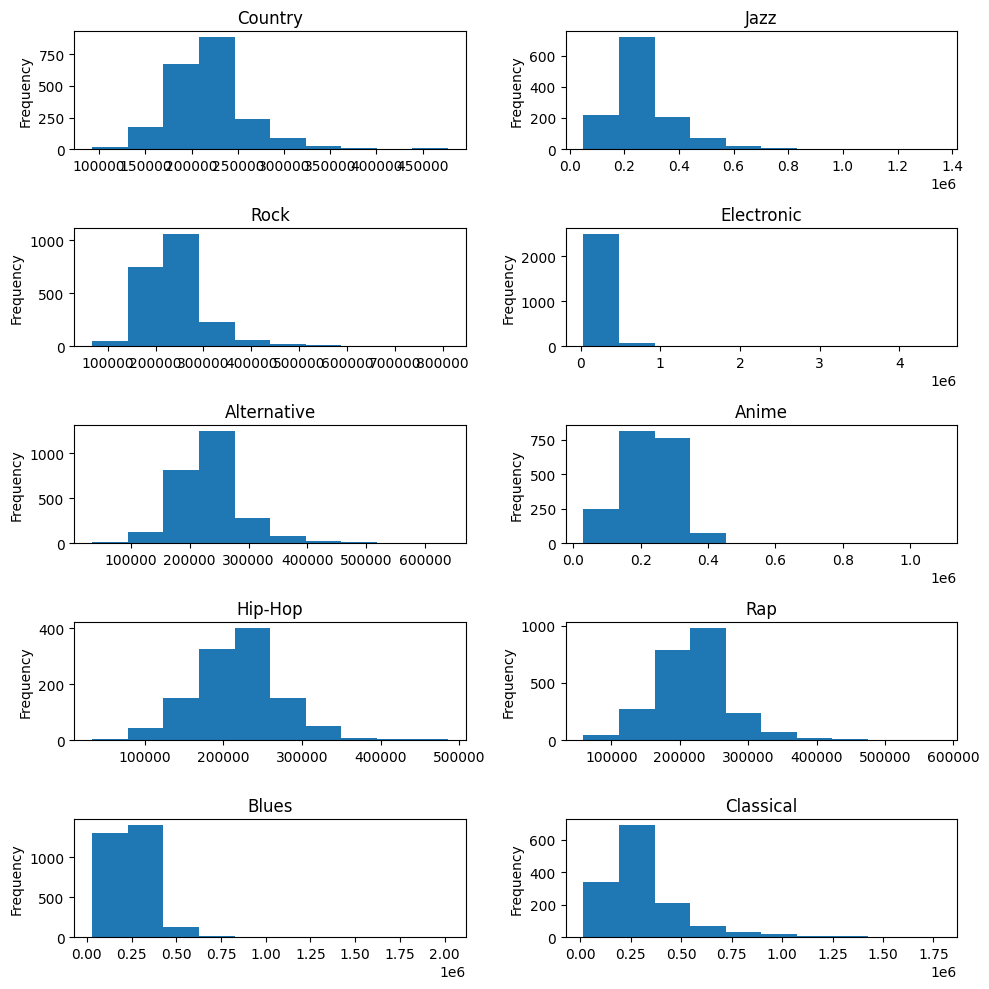

-------------------------------------------------------------
all_features_sum


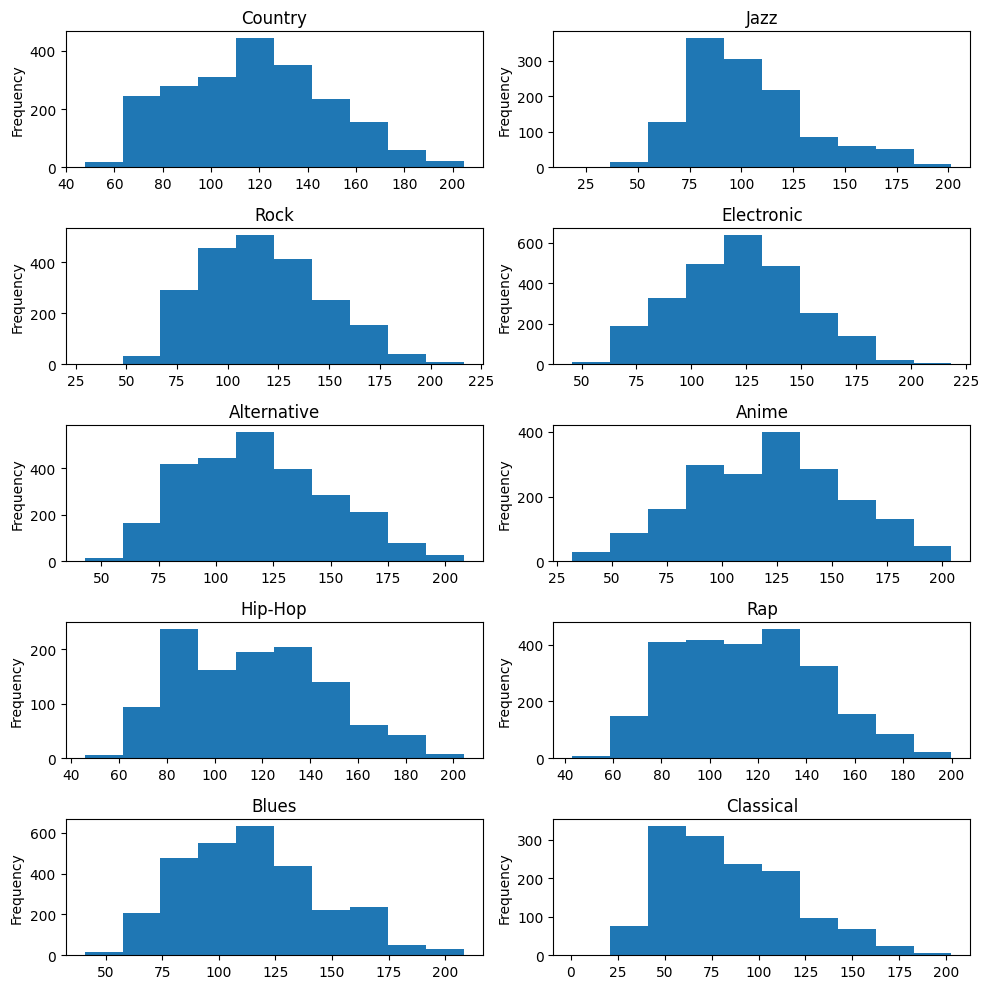

-------------------------------------------------------------
all_features_sum_per_sec


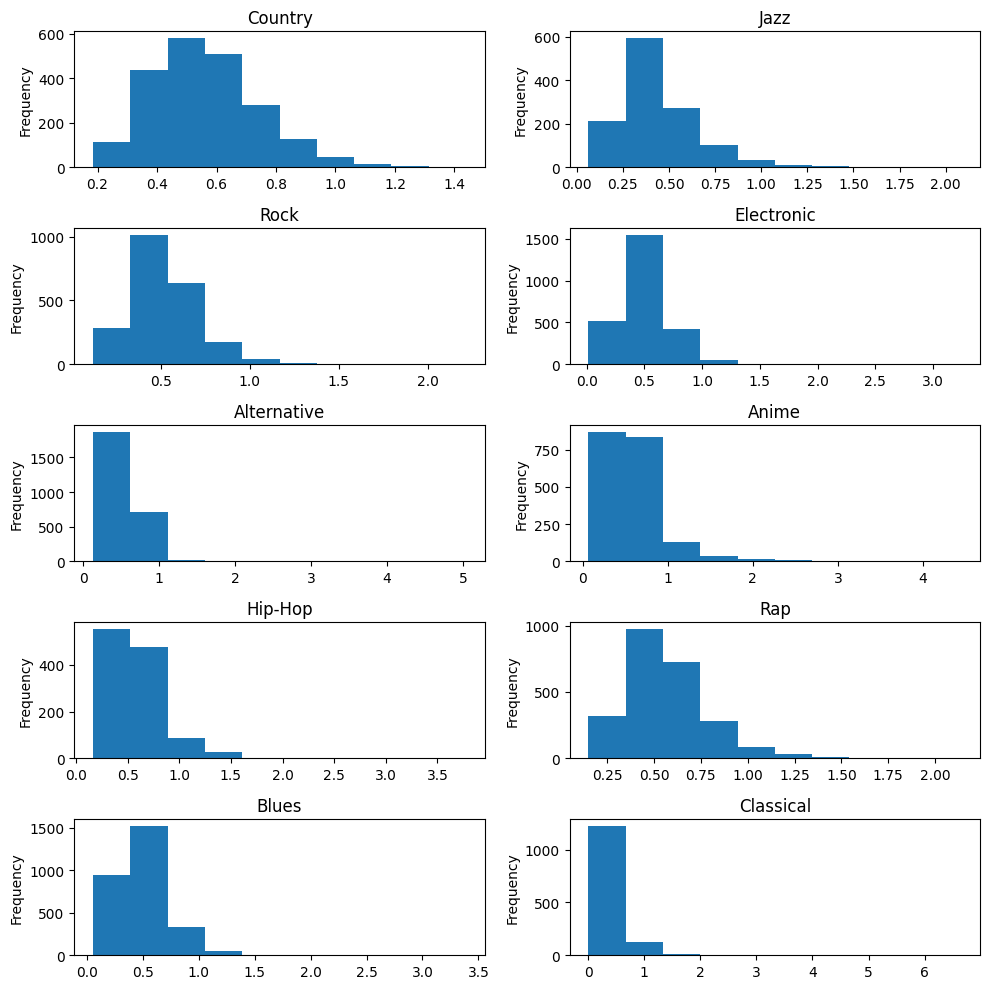

-------------------------------------------------------------


In [43]:
# Гистограмы новых факторов в разрезе жанров
new_cols = ['mode', 'classical_flag','electronic_flag', 'love_flag', 'anime_flag', 'feat_flag', 'duration_m',
            'energy_dance_score', 'sound_intensity', 'combined_liveness_valence',
            'acoustic_instrumental_factor', 'expressive_complexity',
            'emotional_expression', 'liveliness', 'mood_score',
            'popularity_rating', 'all_features_sum', 'all_features_sum_per_sec']

for col_name in new_cols:
  print(col_name)
  df_check = df[['music_genre', f'{col_name}']]
  df_check = df_check[df_check['music_genre'].isna()==False]

  # Определяем размеры графиков
  fig, axes = plt.subplots(5, 2, figsize=(10, 10))

  # Перебираем каждый музыкальный жанр и строим гистограмму длительности песни
  unique_genres = df_check['music_genre'].unique()
  for i, genre in enumerate(unique_genres):
      row = i % 5
      col = i // 5
      genre_data = df_check[df_check['music_genre'] == genre][f'{col_name}']
      genre_data.plot.hist(ax=axes[row, col])
      axes[row, col].set_title(genre)

  plt.tight_layout()
  plt.show()
  print('-------------------------------------------------------------')

In [44]:
df = df.drop(columns = 'track_name')

In [45]:
df['key'].value_counts()

G     3724
C     2679
D     2667
C#    2620
A     2478
F     2080
B     1919
E     1865
G#    1582
A#    1578
F#    1539
D#     762
Name: key, dtype: int64

In [46]:
# Преобразование фактора key в дамми-переменные
df = pd.get_dummies(df, columns=['key'], drop_first = True)
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,0.301000,0.757,146213.00000,0.679,0.00000,0.3030,-7.136,0,0.3560,90.361,...,0,0,0,0,0,0,0,0,0,0
1,0.538000,0.256,240360.00000,0.523,0.00832,0.0849,-5.175,1,0.0294,78.385,...,0,0,0,0,0,0,0,0,0,1
2,0.005830,0.678,284000.00000,0.770,0.00000,0.1090,-4.399,0,0.2220,90.000,...,0,0,0,0,0,0,0,0,0,0
3,0.020300,0.592,177354.00000,0.749,0.00000,0.1220,-4.604,1,0.0483,160.046,...,1,0,0,0,0,0,0,0,0,0
4,0.000335,0.421,239001.98697,0.447,0.01480,0.0374,-8.833,1,0.2020,73.830,...,0,0,0,1,0,0,0,0,0,0


In [47]:
df.shape

(25493, 40)

In [48]:
# Выделение категориальных полей
categorical = list(df.dtypes[(df.dtypes == "object")].index) # | (df.dtypes == "int64")
categorical

['music_genre']

In [49]:
# Выделение числовых полей
numerical = list(df.dtypes[(df.dtypes == "float64")].index) # | (df.dtypes == "int64")
numerical

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'duration_m',
 'energy_dance_score',
 'sound_intensity',
 'combined_liveness_valence',
 'acoustic_instrumental_factor',
 'expressive_complexity',
 'emotional_expression',
 'liveliness',
 'mood_score',
 'popularity_rating',
 'all_features_sum',
 'all_features_sum_per_sec']

In [50]:
# Определение границ выбросов (межквартильный размах)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Замена выбросов на верхнюю границу
for column in numerical:
    df[column] = df[column].apply(lambda x: upper_bound[column] if x > upper_bound[column] else x)

# Замена выбросов на нижнюю границу
for column in numerical:
    df[column] = df[column].apply(lambda x: lower_bound[column] if x < lower_bound[column] else x)

<ipython-input-50-44833d2b00ed>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
<ipython-input-50-44833d2b00ed>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)


In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,25493.0,0.275092,0.321841,0.000000,0.015400,0.120000,0.46900,0.996000
danceability,25493.0,0.562106,0.171224,0.104500,0.451000,0.570000,0.68200,0.978000
duration_ms,25493.0,236479.716832,64461.766083,84848.000000,195707.000000,231110.795139,269613.00000,380472.000000
energy,25493.0,0.624627,0.251354,0.001010,0.469000,0.665000,0.83000,0.999000
instrumentalness,25493.0,0.054260,0.088297,0.000000,0.000000,0.000146,0.08590,0.214750
liveness,25493.0,0.184480,0.123543,0.013600,0.097200,0.129000,0.25200,0.484200
loudness,25493.0,-8.143889,4.231632,-18.025500,-10.248000,-7.066000,-5.06300,2.714500
mode,25493.0,0.653513,0.475860,0.000000,0.000000,1.000000,1.00000,1.000000
speechiness,25493.0,0.075179,0.054712,0.022300,0.035600,0.049000,0.09580,0.186100
tempo,25493.0,121.000388,29.972622,34.765000,96.084000,120.758000,140.97900,208.321500


## Выбор и обучение моделей

In [52]:
df_train = pd.DataFrame(df[pd.isna(df['music_genre'])==False])
df_test = pd.DataFrame(df[pd.isna(df['music_genre'])==True]).drop(columns='music_genre')

In [53]:
y = df_train["music_genre"]
X = df_train.drop(columns=["music_genre"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
# SVM MODEL
param_grid = {'svm__C': [0.1, 1, 10],
              'svm__gamma': [1, 0.1, 0.01],
              'svm__kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ("imputer", SimpleImputer()),
                       ("fs", SelectKBest(score_func=f_classif, k="all")),
                       ('svm', SVC())])



search = GridSearchCV(pipe, param_grid, n_jobs=1, cv=3 , scoring=f1)

search.fit(X_train, y_train)

preds = search.predict(X_train)
preds_test = search.predict(X_test)

# оценка качества
f1_train = f1_score(y_train, preds, average = 'micro')
f1_test = f1_score(y_test, preds_test, average = 'micro')

print("f1_score of SVM Model on train: ", f1_svm_train)
print("f1_score of SVM Model on test: ", f1_svm_test)

f1_score of SVM Model on train:  0.530238640078457
f1_score of SVM Model on test:  0.46636595410864873


In [ ]:
# RandomForestClassifier
f1 = make_scorer(f1_score, average="micro")
param_grid = {'classifier__n_estimators': [5, 10, 50, 100],
              'classifier__max_features' : [None, 3 ,5],
              'classifier__max_depth':[None, 3, 5]}

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ("imputer", SimpleImputer()),
                       ("fs", SelectKBest(score_func=f_classif, k="all")),
                       ('classifier', RandomForestClassifier())])

search = GridSearchCV(pipe, param_grid, n_jobs=1, cv=3 , scoring=f1)

search.fit(X_train, y_train)

preds = search.predict(X_train)
preds_test = search.predict(X_test)

# оценка качества
f1_train = f1_score(y_train, preds, average = 'micro')
f1_test = f1_score(y_test, preds_test, average = 'micro')

print("f1_score of RandomForestClassifier Model on train: ", f1_train)
print("f1_score of RandomForestClassifier Model on test: ", f1_test)

f1_score of SVM Model on train:  0.530238640078457
f1_score of SVM Model on test:  0.46636595410864873


In [ ]:
# catboost
f1 = make_scorer(f1_score, average="micro")
param_grid = {'classifier__depth'         : [4,5,6,7,8,9, 10],
                 'classifier__learning_rate' : [0.01,0.02,0.03,0.04],
                  'classifier__iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ("imputer", SimpleImputer()),
                       ("fs", SelectKBest(score_func=f_classif, k="all")),
                       ('classifier',CatBoostClassifier(verbose=False))])

search = GridSearchCV(pipe, param_grid, n_jobs=1, cv=3 , scoring=f1)

search.fit(X_train, y_train)

preds = search.predict(X_train)
preds_test = search.predict(X_test)

# оценка качества
f1_train = f1_score(y_train, preds, average = 'micro')
f1_test = f1_score(y_test, preds_test, average = 'micro')

print("f1_score of CatBoostClassifier Model on train: ", f1_train)
print("f1_score of CatBoostClassifier Model on test: ", f1_test)

In [ ]:
f1_test

In [54]:
cb = CatBoostClassifier()
cb.fit(X_train, y_train)
preds = cb.predict(X_test)

Learning rate set to 0.090936
0:	learn: 2.1979086	total: 253ms	remaining: 4m 13s
1:	learn: 2.1186022	total: 422ms	remaining: 3m 30s
2:	learn: 2.0555696	total: 598ms	remaining: 3m 18s
3:	learn: 2.0012349	total: 772ms	remaining: 3m 12s
4:	learn: 1.9590467	total: 930ms	remaining: 3m 5s
5:	learn: 1.9179695	total: 1.06s	remaining: 2m 55s
6:	learn: 1.8800397	total: 1.22s	remaining: 2m 52s
7:	learn: 1.8485709	total: 1.35s	remaining: 2m 47s
8:	learn: 1.8206917	total: 1.52s	remaining: 2m 47s
9:	learn: 1.7963341	total: 1.67s	remaining: 2m 45s
10:	learn: 1.7708288	total: 1.79s	remaining: 2m 40s
11:	learn: 1.7511983	total: 1.96s	remaining: 2m 40s
12:	learn: 1.7301115	total: 2.12s	remaining: 2m 41s
13:	learn: 1.7081245	total: 2.29s	remaining: 2m 41s
14:	learn: 1.6883889	total: 2.45s	remaining: 2m 40s
15:	learn: 1.6716713	total: 2.64s	remaining: 2m 42s
16:	learn: 1.6576507	total: 2.79s	remaining: 2m 41s
17:	learn: 1.6430799	total: 2.92s	remaining: 2m 39s
18:	learn: 1.6303200	total: 3.05s	remaining: 

## Оценка качества

In [55]:
f1_score(y_test, preds, average = 'micro')

0.5248087860364777

In [ ]:
# 0.5189252794665621

In [ ]:
y = df_train["music_genre"]
X = df_train.drop(columns=["music_genre"])

best_state = -1
f1_best = 0
for i in range(0, 50):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=i)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train[numerical])
  X_test = scaler.transform(X_test[numerical])
  cb = CatBoostClassifier(verbose = False)
  cb.fit(X_train, y_train)
  preds = cb.predict(X_test)
  f1 = f1_score(y_test, preds, average = 'micro')
  print(i, f1)
  if f1>f1_best:
    f1_best = f1
    best_state = i

0 0.5118650715826633
1 0.509511668954697
2 0.49186114924495
3 0.5075505000980585
4 0.5059815650127476
5 0.5199058638948814
6 0.5071582663267308
7 0.5102961364973524
8 0.5126495391253187
9 0.5097077858403608
10 0.5036281623847814
11 0.5238282016081585
12 0.506766032555403
13 0.5026475779564621
14 0.5097077858403608
15 0.515002941753285
16 0.5008825259854873
17 0.5128456560109825
18 0.4989213571288488
19 0.5083349676407138
20 0.5022553441851343
21 0.515002941753285
22 0.49715630515787407
23 0.5014708766424789
24 0.5050009805844283
25 0.5026475779564621
26 0.509511668954697
27 0.5024514610707982
28 0.50813885075505
29 0.5085310845263777
30 0.5110806040400079
31 0.5171602274955873
32 0.5167679937242596
33 0.5059815650127476
34 0.5048048636987644
35 0.5091194351833693
36 0.5065699156697392
37 0.5061776818984115
38 0.504020396156109
39 0.5026475779564621
40 0.5061776818984115
41 0.5085310845263777
42 0.5189252794665621
43 0.5132378897823102
44 0.5106883702686801
45 0.5153951755246127
46 0.50

In [ ]:
f1_best

0.5238282016081585

In [ ]:
best_state

11

## Анализ важности признаков модели

In [56]:
# Feature importance
importances = cb.feature_importances_
feature_list = list(X.columns)

feature_importance= sorted(zip(importances, feature_list), reverse=True)

dff = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(dff['importance'])
feature= list(dff['feature'])

dff.head(50)

,importance,feature
0,11.248856,speechiness
1,9.621436,danceability
2,8.601740,instrumentalness
3,6.459493,acousticness
4,6.332882,valence
5,5.759622,loudness
6,5.166625,energy
7,5.051342,acoustic_instrumental_factor
8,4.322725,energy_dance_score
9,3.974403,popularity_rating


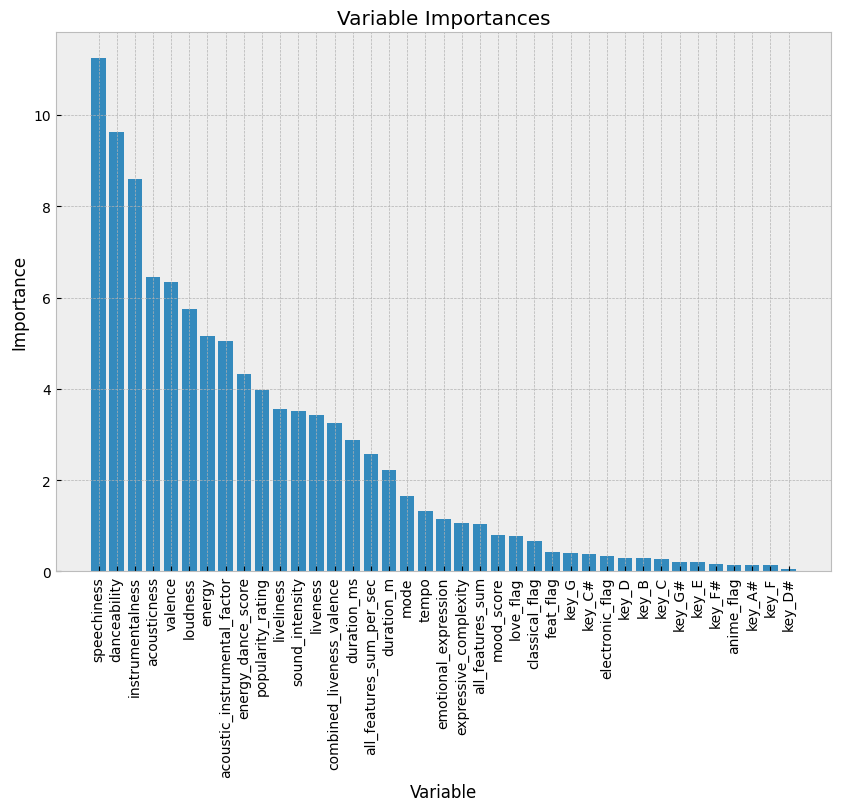

In [59]:
plt.style.use('bmh')
x_values = list(range(len(feature_importance)))
plt.figure(figsize=(10,7))
plt.bar(x_values, importance, orientation = 'vertical')
plt.xticks(x_values, feature, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');